#### **Introduction**

In the last few years, several cities across the world have experienced an explosive growth in Airbnb. What started as a shared economy platform for informal home-sharing has recently transformed into a major short-term rental market which fills the gap between traditional residential rental housing and hotel accommodation (Giovanni). While Airbnb advocates argue that the platform brings extra incomes to its users and new economic activities to cities, many raise concerns about its impact on housing markets through loss of housing supply, increased rent and gentrification (NYC, gentrification).

This report is motivated by claims that Airbnb is ‘out of control’ in London, and specifically addresses the recent proposal to force all professional landlords operating on the platform to register their properties and face higher Council Tax rates. Using comprehensive empirical analysis, we aim to answer five questions:

1.	Is Airbnb ‘out of control’ in London?
2.	How many professional landlords are there?
3.	How many properties would be affected by the proposal?
4.	What are the likely pros and cons of the proposal (for the Mayor, residents, and the city)?
5.	Can the story be reframed as a positive one about social mobility or housing opportunity?

Our investigation uses the Inside Airbnb (IA) dataset to analyse Airbnb activity for more than **xxx** million listings in London. To determine the impact of Airbnb on the housing market, we use average monthly rents in private rental market aggregated at the borough level. The potential impact of introducing higher Council Tax rates to professional landlords is explored using Council Tax data at the borough level.


#### Data and methodologies

Our investigation relies heavily on the Inside Airbnb dataset, which scrapes publicly available listing information from the Airbnb platform. The Inside Airbnb dataset is commonly used in research, presumably because it is one of the only publicly-accessible datasets currently available. However, it is not without serious limitations which need consideration. Importantly, the dataset acts as a snapshot of listing information as it appeared on the day of scraping, making much of the data unreliable because the host could change these inputs (such as price and minimum-stay requirements) at any given moment. In 2015, Airbnb stopped disclosing the difference between nights that are booked by guests and nights that are ‘blacked-out’ by hosts, making it impossible to precisely measure occupancy and revenue (NYC). Where assumptions are made, our findings provide conservative estimates for occupancy and revenue – these values are likely much higher. 


Other **limitations** that might need discussing (depending on how many words we have at the end):
- "Although each Airbnb listing is specified on the public Airbnb website with exact latitude and longitude coordinates, these coordinates have been shifted from the real location by up to 150m in a random direction (in order to protect hosts’ privacy). This randomness means that maps which show the exact locations of listings (or rely on these locations for their analyses) are misleading inasmuch as they exaggerate the precision of the underlying spatial data." - NYC paper

In [ ]:
# --- Part 01 Data Loading ---
# The Work Mythology in Part 01 Data Loading and Initial Cleaning:
# Steps:
# 1) Import Packages
# 2) Ensuring Folder Structure, a main file named data, and subfolders: Raw and Clean.
# 3) Download files from the Web into a raw file in the home repository
# 4) Additional Data loading, such as converting and unzipping a  file
# 5) Identifying which columns to keep from the raw file structure
# 6) Build CLEAN versions in data/clean (from RAW)
# 7) Load from data/clean with selected columns
# 8) Clean column names function that does the initial cleaning on the data before in-depth analysis

In [1]:
# Step 01 - Import packages needed for analysis
import os
import urllib.request
import zipfile
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Step 02 - Ensuring Folder Structure: Create a main file named data and subfolders named raw and clean.
def ensure_data_folders():
    folders = ["data/raw", "data/clean"]
    
    for folder in folders:
        if not os.path.isdir(folder):
            os.makedirs(folder)
            print(f"Created folder: {folder}")
        else:
            print(f"Folder already exists: {folder}")

    print("--" * 30)

ensure_data_folders()

Folder already exists: data/raw
Folder already exists: data/clean
------------------------------------------------------------


In [3]:
# Step 03 - Download files from the Web into a raw file on the home repository
# Please Note: The gitignore file includes the whole of the data file so that you won't see this file in the main repo

# function that downloads  files into raw only if they don't exist
def download_if_missing(url, local_name):
    dest = os.path.join("data", "raw", local_name)
    
    print(f"Let me check: {local_name}")

    if os.path.isfile(dest):
        print("File already exists — skipping download.")
    else:
        print(f"Downloading from:\n    {url}")
        urllib.request.urlretrieve(url, dest)
        print("Download complete — saved.")

    print("--" * 20)
    return dest 

# attribute url path to a variable Source: Prof. Jon Reades from the CASA department at UCL
base = "https://orca.casa.ucl.ac.uk/~jreades/data/"

# files we wish to download  from that path 
orca_files = [
    
    "20250615-London-listings.csv.gz",
    # ^ Airbnb listings from calendar "screenshot" 15/June/2025 (comma-separated values)
    "MSOA-2011.gpkg" 
    # ^ Middle-Layer Super Output Area for London (Spatial file)
]

# Extra files we saw necessary to add for further analysis (Outside the scope offered by Prof. Reades)
extra_files = {
    
    "housing_msoa.csv":
        "https://data.london.gov.uk/download/2z0yn/20264159-36cb-4aa2-8371-ae884ae83e88/msoa-data.csv",
        # ^ Housing data by MSOA boundaries to evaluate how many households are in a jurisdictional boundary (comma-separated values)    
        
    "londonrentalstatsaccessibleq22024.xlsx":
        "https://www.ons.gov.uk/file?uri=/economy/inflationandpriceindices/adhocs/2224privaterentalmarketinlondonjuly2023tojune2024/londonrentalstatsaccessibleq22024.xlsx",
       # ^ Average monthly Rent according to Borough (Excel must transform to comma-separated values)
   
    "london_boroughs.zip":
        "https://data.london.gov.uk/download/20od9/08d31995-dd27-423c-a987-57fe8e952990/London-wards-2018.zip",
        # ^ Borough Boundary of London (Spatial file)
    
    "council_tax_borough.xlsx":
        "https://data.london.gov.uk/download/expnl/59cc7c37-da8f-4158-bc47-491c3d167b05/council-tax-bands-borough.xlsx"
        # ^ Council Tax per Borough Band D (Excel must transform to comma-separated values)
}

local_paths = [] # Open List for later for-loop

# Orca files download to raw file
print("!STARTING ORCA DOWNLOADS!")
for fname in orca_files:
    url = base + fname
    path = download_if_missing(url, fname) 
    local_paths.append(path)

# Extra files download to raw file
print("!STARTING DATASTORE DOWNLOADS!")
for local_name, url in extra_files.items():
    path = download_if_missing(url, local_name)
    local_paths.append(path)

!STARTING ORCA DOWNLOADS!
Let me check: 20250615-London-listings.csv.gz
File already exists — skipping download.
----------------------------------------
Let me check: MSOA-2011.gpkg
File already exists — skipping download.
----------------------------------------
!STARTING DATASTORE DOWNLOADS!
Let me check: housing_msoa.csv
File already exists — skipping download.
----------------------------------------
Let me check: londonrentalstatsaccessibleq22024.xlsx
File already exists — skipping download.
----------------------------------------
Let me check: london_boroughs.zip
File already exists — skipping download.
----------------------------------------
Let me check: council_tax_borough.xlsx
File already exists — skipping download.
----------------------------------------


In [4]:
# Step 04 -  Additional Data loading, such as converting Excel to CSV and unzipping a file
#            in the condition that the files haven't done this

# Convert the Rent file from Excel to CSV
print("!CONVERTING RENT EXCEL (Number 2 sheet) TO CSV!")
    
excel_path = "data/raw/londonrentalstatsaccessibleq22024.xlsx"
csv_path   = "data/raw/londonrentalstatsaccessibleq22024.csv"

if os.path.isfile(csv_path):
    print(f"CSV already exists, skipping conversion: {csv_path}")
else:
    if not os.path.isfile(excel_path):
        print(f"Excel file not found: {excel_path}")
    else:
        rents_xlsx = pd.read_excel(
            excel_path,
            sheet_name="2",
            skiprows = 2
        )
        rents_xlsx.to_csv(csv_path, index=False)
        print(f"Converted Excel to CSV: {csv_path}")

print("--" * 20)


# Convert Council Tax file from Excel to CSV
print("!CONVERTING COUNCIL TAX EXCEL (2024-2025) TO CSV!")

excel_path = "data/raw/council_tax_borough.xlsx"
csv_path   = "data/raw/council_tax_borough.csv"

if os.path.isfile(csv_path):
    print(f"CSV already exists, skipping conversion: {csv_path}")
else:
    if not os.path.isfile(excel_path):
        print(f"Excel file not found: {excel_path}")
    else:
        tax_xlsx = pd.read_excel(
            excel_path,
            sheet_name="2024-25"
        )
        tax_xlsx.to_csv(csv_path, index=False)
        print(f"Converted Excel to CSV: {csv_path}")

print("--" * 20)

print("!UNZIPPING LONDON BOROUGHS SHAPEFILE!")

# unzipping Shape File of London Borough
zip_path = "data/raw/london_boroughs.zip"
if os.path.isfile(zip_path):
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall("data/raw/")
    print("Unzipped london_boroughs.zip")
else:
    print("Zip file not found: data/raw/london_boroughs.zip")

print("--" * 20)

!CONVERTING RENT EXCEL (Number 2 sheet) TO CSV!
CSV already exists, skipping conversion: data/raw/londonrentalstatsaccessibleq22024.csv
----------------------------------------
!CONVERTING COUNCIL TAX EXCEL (2024-2025) TO CSV!
CSV already exists, skipping conversion: data/raw/council_tax_borough.csv
----------------------------------------
!UNZIPPING LONDON BOROUGHS SHAPEFILE!
Unzipped london_boroughs.zip
----------------------------------------


In [5]:
# Step 05 - Identifying which columns to keep from raw file structure

# Columns needed for listings 
cols_listings = [
    'id', 'name', 'host_id', 'host_is_superhost', 
    'host_total_listings_count',
    'neighbourhood_cleansed', 'latitude', 'longitude', 
    'property_type', 'room_type', 'bedrooms', 'accommodates', 
    'price', 'minimum_nights', 'maximum_nights', 
    'minimum_minimum_nights','maximum_minimum_nights',
    'minimum_maximum_nights','maximum_maximum_nights',
    'minimum_nights_avg_ntm','maximum_nights_avg_ntm',
    'availability_365',
    'number_of_reviews', 
    'number_of_reviews_ltm',
    'first_review', 'last_review',
    'review_scores_rating', 
    'calculated_host_listings_count',
    'calculated_host_listings_count_entire_homes',
    'calculated_host_listings_count_private_rooms',
    'calculated_host_listings_count_shared_rooms',
    'reviews_per_month',
    'estimated_revenue_l365d',
    'estimated_occupancy_l365d'
]

# Housing (2011 only)*** The housing  is only from 2011 add as a problem for the data
cols_housing = ["Middle Super Output Area",
                 "MSOA Name",
                 "Households (2011);All Households;"
                 ]

# Council tax: band D comparison as it is the Band used as reference by the GLA !!! ADD REF
cols_tax = [
    "Code",
    "Local authority",
    "Band D"
]

In [6]:
# Step 06 -  Build CLEAN versions in data/clean (from RAW)
# Each File goes through the raw version and into clean which would allow us to manipulate the data without losing the raw

print("!CREATING CLEAN VERSIONS!")

# Save listings into a clean file
raw_listings_path = "data/raw/20250615-London-listings.csv.gz"
clean_listings_path = "data/clean/20250615-London-listings.csv.gz"

if not os.path.isfile(clean_listings_path):
    listings_raw = pd.read_csv(
        raw_listings_path,
        compression="gzip",
        encoding="latin1",
        low_memory=False
    )
    listings = listings_raw[cols_listings]
    listings.to_csv(
        clean_listings_path,
        index=False,
        compression="gzip"
    )
    print("Saved cleaned listings to data/clean")
else:
    print("Clean listings already exist, skipping.")

# save MSOA into clean file
raw_msoa_path = "data/raw/MSOA-2011.gpkg"
clean_msoa_path = "data/clean/MSOA-2011.gpkg"

if not os.path.isfile(clean_msoa_path):
    msoa = gpd.read_file(raw_msoa_path)
    msoa.to_file(clean_msoa_path, driver="GPKG")
    print("Saved MSOA to data/clean")
else:
    print("Clean MSOA already exists, skipping.")

# Save Rent into clean file (already converted to CSV in raw)
raw_rent_path = "data/raw/londonrentalstatsaccessibleq22024.csv"
clean_rent_path = "data/clean/londonrentalstatsaccessibleq22024.csv"

if not os.path.isfile(clean_rent_path):
    rent = pd.read_csv(raw_rent_path, encoding="latin1", low_memory=False)
    rent.to_csv(clean_rent_path, index=False)
    print("Saved cleaned rent to data/clean")
else:
    print("Clean rent already exists, skipping.")

# Save Housing into clean file
raw_housing_path = "data/raw/housing_msoa.csv"
clean_housing_path = "data/clean/housing_msoa.csv"

if not os.path.isfile(clean_housing_path):
    housing_raw = pd.read_csv(raw_housing_path, encoding="latin1", low_memory=False)
    housing = housing_raw[cols_housing]
    housing.to_csv(clean_housing_path, index=False)
    print("Saved cleaned housing to data/clean")
else:
    print("Clean housing already exists, skipping.")

# Save Borough and Wards into a clean file
borough_clean_dir = "data/clean/London-wards-2018_ESRI"
os.makedirs(borough_clean_dir, exist_ok=True)

# this path depends on how the zip unzips 
raw_borough_path = "data/raw/London-wards-2018_ESRI/London_Ward.shp"

clean_borough_path = os.path.join(borough_clean_dir, "London_Ward.shp")

if not os.path.isfile(clean_borough_path):
    borough = gpd.read_file(raw_borough_path)
    borough.to_file(clean_borough_path)
    print("Saved borough shapefile to data/clean")
else:
    print("Clean borough shapefile already exists, skipping.")

# Save Council Tax file into clean file
raw_tax_path = "data/raw/council_tax_borough.csv"
clean_tax_path = "data/clean/council_tax_borough.csv"

if not os.path.isfile(clean_tax_path):
    council_tax_raw = pd.read_csv(raw_tax_path, encoding="latin1", low_memory=False)
    council_tax = council_tax_raw[cols_tax]
    council_tax.to_csv(clean_tax_path, index=False)
    print("Saved cleaned council tax to data/clean")
else:
    print("Clean council tax already exists, skipping.")

print("**All cleaned files saved to data/clean/**")


!CREATING CLEAN VERSIONS!
Clean listings already exist, skipping.
Clean MSOA already exists, skipping.
Clean rent already exists, skipping.
Clean housing already exists, skipping.
Clean borough shapefile already exists, skipping.
Clean council tax already exists, skipping.
**All cleaned files saved to data/clean/**


In [7]:
# Step 07 -  Load from data/clean with selected columns and attirbute to a value 

print("!LOADING FILES (SELECTED COLUMNS ONLY)!")

# Load Listings
listings = pd.read_csv(
    "data/clean/20250615-London-listings.csv.gz",
    compression="gzip",
    usecols=cols_listings,
    encoding="latin1",
    low_memory=False
)
print(f"Step 01: listings loaded: {listings.shape[0]:,} rows, {listings.shape[1]} columns")

# Load MSOA
msoa = gpd.read_file("data/clean/MSOA-2011.gpkg")
print(f"Step 02: msoa loaded: {msoa.shape[0]:,} polygons, {msoa.shape[1]} columns")

# Rent
rent = pd.read_csv(
    "data/clean/londonrentalstatsaccessibleq22024.csv",
    encoding="latin1",
    low_memory=False
)
print(f"Step 03: rent loaded: {rent.shape[0]:,} rows, {rent.shape[1]} columns")

# Load Housing
housing = pd.read_csv(
    "data/clean/housing_msoa.csv",
    usecols=cols_housing,
    encoding="latin1",
    low_memory=False
)
print(f"Step 04: housing loaded: {housing.shape[0]:,} rows, {housing.shape[1]} columns")

# Load Borough boundary polygons
borough = gpd.read_file("data/clean/London-wards-2018_ESRI/London_Ward.shp")
print(f"Step 05: borough loaded: {borough.shape[0]:,} polygons, {borough.shape[1]} columns")

# Load Council Tax
council_tax = pd.read_csv(
    "data/clean/council_tax_borough.csv",
    usecols=cols_tax,
    encoding="latin1",
    low_memory=False
)
print(f"Step 06: council tax loaded: {council_tax.shape[0]:,} rows, {council_tax.shape[1]} columns")


# Print this when done
print("**All selected files successfully loaded.**")

!LOADING FILES (SELECTED COLUMNS ONLY)!
Step 01: listings loaded: 96,651 rows, 34 columns
Step 02: msoa loaded: 983 polygons, 13 columns
Step 03: rent loaded: 198 rows, 7 columns
Step 04: housing loaded: 984 rows, 3 columns
Step 05: borough loaded: 657 polygons, 7 columns
Step 06: council tax loaded: 34 rows, 3 columns
**All selected files successfully loaded.**


In [8]:
# Step 08 - Clean column names function that does the initial cleaning on the data before in-depth analysis

# Create a function clean_names that runs through the data frame
def clean_names(df):
    df = df.copy()
    df.columns = (
        df.columns
        .str.strip()
        .str.lower()
        .str.replace(" ", "_")
        .str.replace(r"[^\w]", "", regex=True)
        .str.replace(",", "", regex=False)
    )
    return df

# turn data frame into a dictionary for fast cleaning
dfs = {
    "listings": listings,
    "msoa": msoa,
    "rent": rent,
    "housing": housing,
    "borough": borough,
    "council_tax": council_tax
}
for name, frame in dfs.items():
    dfs[name] = clean_names(frame)
    print(f"Cleaned column names for: {name}")

# Reverse the dictionary back to individual data frames 
listings     = dfs["listings"]
msoa         = dfs["msoa"]
rent         = dfs["rent"]
housing      = dfs["housing"]
borough      = dfs["borough"]
council_tax  = dfs["council_tax"]

Cleaned column names for: listings
Cleaned column names for: msoa
Cleaned column names for: rent
Cleaned column names for: housing
Cleaned column names for: borough
Cleaned column names for: council_tax


In [ ]:
# --- Part 02 Data Cleaning ---
# Removing null values, changing classes, merging values ...
# Steps:
# 1) Cleaning the LISTINGS Dataframe
# 2) Cleaning the BOROUGH Dataframe

In [9]:
# Step 01 - listings cleaning
probs = listings.isnull().sum(axis=1)
listings.isnull().sum(axis=1).sort_values(ascending=False).head(10)

5155     8
81967    8
52385    8
87339    8
3646     8
46883    8
75068    8
81475    8
54661    8
6122     8
dtype: int64

In [10]:
# If a row has more than 5 null values, we remove and see as not fit data
print(f"listings contains {listings.shape[0]:,} rows.")
cutoff = 5
listings.drop(probs[probs > cutoff].index, inplace=True)
print(f"listings contains {listings.shape[0]:,} rows.")

listings contains 96,651 rows.
listings contains 86,483 rows.


In [11]:
# Check Where are the null values
listings.isnull().sum(axis=0).sort_values(ascending=False)
listings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 86483 entries, 0 to 96650
Data columns (total 34 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            86483 non-null  int64  
 1   name                                          86483 non-null  object 
 2   host_id                                       86483 non-null  int64  
 3   host_is_superhost                             84736 non-null  object 
 4   host_total_listings_count                     86451 non-null  float64
 5   neighbourhood_cleansed                        86483 non-null  object 
 6   latitude                                      86483 non-null  float64
 7   longitude                                     86483 non-null  float64
 8   property_type                                 86483 non-null  object 
 9   room_type                                     86483 non-null  obje

In [12]:
# Converting Values into readable values for data wrangling and analysis 
# boolean values
bools = ['host_is_superhost']
for b in bools:
    print(f"Converting {b} to boolean")
    listings[b] = listings[b].replace({'f':False, 't':True}).astype('bool')

# categories
cats = ['property_type','room_type']
for c in cats:
    print(f"Converting {c} to categort")
    listings[c] = listings[c].astype('category')

# dates
dates = ['first_review','last_review']
for d in dates:
    print(f"Converting {d} to date")
    listings[d] = pd.to_datetime(listings[d])

# strings
money = ['price']
for m in money:
    print(f"Converting {m} to float")
    listings[m] = (
        listings[m]
        .astype(str)            # convert to string so .str works
        .str.replace('$', '', regex=False)
        .str.replace(',', '')
        .replace('nan', float('nan'))  # optional: fix 'nan' strings
        .astype(float))

# integers
ints  = ['id','host_id','host_total_listings_count','bedrooms','accommodates', 'minimum_nights','maximum_nights','availability_365']
for i in ints:
    print(f"Converting {i} to integer")
    try:
        listings[i] = listings[i].astype('float').astype('int')
    except ValueError as e:
        print("  - !!!Converting to unsigned 16-bit integer!!!")
        listings[i] = listings[i].astype('float').astype(pd.UInt16Dtype())

listings.info()

Converting host_is_superhost to boolean
Converting property_type to categort
Converting room_type to categort
Converting first_review to date
Converting last_review to date
Converting price to float
Converting id to integer
Converting host_id to integer
Converting host_total_listings_count to integer
  - !!!Converting to unsigned 16-bit integer!!!
Converting bedrooms to integer
  - !!!Converting to unsigned 16-bit integer!!!
Converting accommodates to integer
Converting minimum_nights to integer
Converting maximum_nights to integer
Converting availability_365 to integer
<class 'pandas.core.frame.DataFrame'>
Index: 86483 entries, 0 to 96650
Data columns (total 34 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            86483 non-null  int64         
 1   name                                          86483 non-null  object

In [13]:
# Step 02 -  Clean the Borough Shapefile

# Ensure CRS is correct to match Airbnb points later
borough = borough.to_crs(epsg=4326)

# Extract borough code from lagsscode
borough['borough_code'] = (
    borough['lagsscode']
    .astype(str)
    .str.strip())

# Clean borough name from shapefile
borough['borough_name'] = (
    borough['district']
    .astype(str)
    .str.lower()
    .str.replace("&", "and", regex=False)
    .str.replace("-", " ", regex=False)
    .str.strip())

# Keep only essential columns
borough_min = borough[['borough_code', 'borough_name', 'geometry']].copy()

# Dissolve all pieces per borough_code into a single geometry (outer boundary of borough)
borough_shp = borough_min.dissolve(by='borough_code')

# Bring borough_code back as a normal column
borough_shp = borough_shp.reset_index()

print("clean borough shapefile:", borough_shp.shape)
print("geom types:", borough_shp.geom_type.value_counts())
display(borough_shp.head())

# Quick visual check (DONT PRINT)
# ax = borough_shp.plot(edgecolor='black', facecolor='none', figsize=(6, 6))

# ---- Output Data -----
# borough_shp = Which is a cleaned, outer boundary (dissolved) shape file of the boroughs.

clean borough shapefile: (33, 3)
geom types: Polygon    33
Name: count, dtype: int64


,borough_code,geometry,borough_name
0,E09000001,"POLYGON ((-0.08904 51.50803, -0.08948 51.50809...",city and county of the city of london
1,E09000002,"POLYGON ((0.09862 51.51492, 0.09811 51.5152, 0...",barking and dagenham
2,E09000003,"POLYGON ((-0.22265 51.56353, -0.22341 51.56413...",barnet
3,E09000004,"POLYGON ((0.12634 51.41472, 0.12628 51.41477, ...",bexley
4,E09000005,"POLYGON ((-0.25603 51.53395, -0.25612 51.53434...",brent


#### **Disscussion 01: Is Airbnb out of control in London?**

Assessing whether Airbnb is “out of control” in London requires defining what this means. In this analysis, Airbnb becomes out of control when short-term rentals grow large enough to (1) reduce the supply of long-term housing, (2) generate strong financial incentives to convert homes away from residential use, and (3) exceed the city’s regulatory capacity—particularly the 90-night annual limit for short-term lets.

Based on the analysis, Airbnb does not appear uniformly “out of control” across London, but its impact is clearly concentrated, uneven, and significant in key areas of the city, particularly in Inner London and in larger family-sized homes.


** Work in progress**





#### Growth of full-time rentals

Growth tendency in airbnb full-time short-term rentals

The dataset does not include the exact date when a property was first listed on Airbnb. However, it does contain the date of the first review. Because hosts typically receive their first review shortly after a guest stays for the first time, **the year of the first review is generally a good proxy for the year the listing became active.**

For this reason, we use the year of the first review as an estimate of the listing’s “introduction year.” Plotting a histogram of these years allows us to visualize how many new Airbnb listings entered the market each year and to observe the growth of the platform over time.

The histogram shows a clear surge in the number of new listings from 2021 onwards, quickly recovering from the Covid-19 pandemic. The strong growth in recent years suggests that Airbnb supply has been accelerating rather than stabilizing.

In [ ]:
# -- The Work Methodology For evaluating If Airbnb is out of control in London:--
# Steps Overview:
# 1. Create a subset of Airbnb full-time listings
# 2. Spatial Join to assigns Listings to MSOA.
# 3. Review the Growth of Airbnb Listings over time
#    Output: **Figure 01**
# 4. Calculate the percentage of full-time Airbnb listings relative to 
#    total households at MSOA level and map the spatial distribution.
#    Output: **Figure 02**
# 5. Clean Rent data set (Could this be moved to data cleaning section? is a short code)
# 6. Classify Airbnb listings into bedroom categories so that 
#    they are directly comparable with the rent dataset.
# 7. Merge the rent data with the borough shapefile and the 
#    borough-level Airbnb revenue estimates.
# 8. Produce scatterplots comparing Airbnb monthly revenue and 
#    private rents by bedroom category.
#    Output: **Figure 03**
# 9. Map the rent gap (Airbnb revenue / private rent) for two-bedroom units 
#    across London boroughs.
#    Output: **Figure 04**
# 10. Zoom in on a high-pressure borough (e.g. Camden) to compare 
#     Airbnb revenue and private rent by unit size and illustrate 
#     local rent gaps in more detail.
#     Output: **Figure 05**

In [14]:
# Step 01: Create a subset of Airbnb full-time listings

# Filter listings where:

# (1) room_type = 'Entire home/apt' -> excludes private rooms/shared rooms
# (2) availability_365 > 90  -> proxy for full-time rental activity

listings_entirehome = listings[
    (listings["room_type"] == "Entire home/apt")
].copy()

listings_fulltime = listings_entirehome[
    (listings_entirehome["availability_365"] > 90) 
].copy()

#Print basic statistics to understand the subset

# What % of all listings are available > 90 days?
print(
    f"Out of {len(listings):,} listings in the Airbnb dataset, "
    f"{len(listings[listings['availability_365'] > 90]):,} listings "
    f"({(len(listings[listings['availability_365'] > 90]) / len(listings)) * 100:.1f}%) "
    f"are available more than 90 days in a year."
)

# What % of listings are whole-home units?
print(
    f"Out of {len(listings):,} listings in the Airbnb dataset, "
    f"{len(listings[listings['room_type'] == 'Entire home/apt']):,} listings "
    f"({(len(listings[listings['room_type'] == 'Entire home/apt']) / len(listings)) * 100:.1f}%) "
    f"are entire home/apartment units."
)

# What % meet both conditions (full-time & entire home)?
print(
    f"Out of {len(listings):,} listings in the Airbnb dataset, "
    f"{len(listings_fulltime):,} listings "
    f"({(len(listings_fulltime) / len(listings)) * 100:.1f}%) "
    f"are entire home/apartment unit, available for more than 90 days in a year."
)

# ---- Output Data -----
# listings_fulltime = Subset Availability >90 days and entire homes

Out of 86,483 listings in the Airbnb dataset, 47,808 listings (55.3%) are available more than 90 days in a year.
Out of 86,483 listings in the Airbnb dataset, 57,571 listings (66.6%) are entire home/apartment units.
Out of 86,483 listings in the Airbnb dataset, 32,206 listings (37.2%) are entire home/apartment unit, available for more than 90 days in a year.


In [15]:
# Step 02: Spatial Join to assign Listings to MSOA

# Convert listings full-time df into Geopandas

listings_fulltime = gpd.GeoDataFrame(
    listings_fulltime,
    geometry=gpd.points_from_xy(
        listings_fulltime.longitude,
        listings_fulltime.latitude
    ),
    crs="EPSG:4326"    
)

# Reproject to Britain National Grid 
listings_fulltime = listings_fulltime.to_crs(epsg=27700)
msoa = msoa.to_crs(epsg=27700)


# Spatial join: assign each Airbnb listing to the MSOA it falls within
# Creates a new dataframe where each listing gets assigned to an MSOA #### within
listings_sjoin = gpd.sjoin(
    listings_fulltime,
    msoa,
    how="left",
    predicate="within"
)

# ---- Output Data -----
# listings_sjoin = data frame of all full-time listings plus the MSOA name it falls within

In [ ]:
 listings_sjoin.head()

#### **Figure 01** | Growth of Airbnb Listings

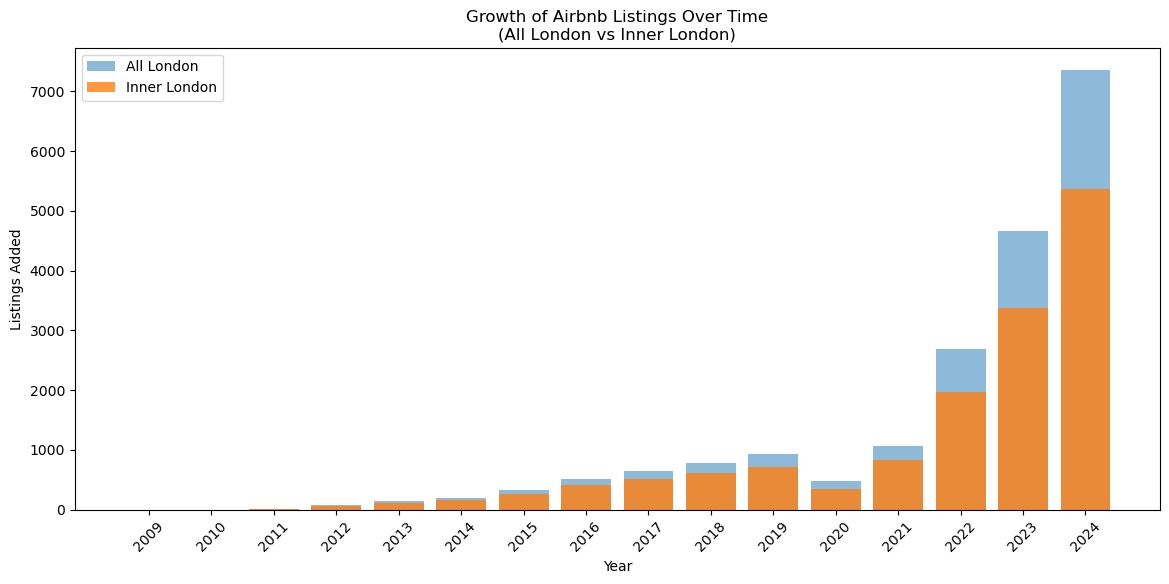

In [17]:
#Step 03: Review the Growth of Airbnb Listings over time, for all of London and specifically for Inner London

# The focus on Inner London is because we hypothesize that most of the new Airbnb listings every year are concentrated in this area.
# Inner London boroughs are characterised by higher housing demand and lower housing supply (fewer housing completions per year)

# Data Limitations: 
#The data does not include the exact date when each listing was first published on the platform. However, it does record the
# date of the first review. Under the assumption that reviews are usually posted shortly after a guest's first stay,
# the year of the first review can be used as a proxy for the year the listing became active.

#Create a new column only with the year of the first review.
listings_sjoin["year_first_review"] = listings_sjoin["first_review"].dt.year.astype("Int64")


# Define the boroughs that belong to inner London 
inner_london = [
    "Camden",
    "Greenwich",
    "Hackney",
    "Hammersmith and Fulham",
    "Islington",
    "Kensington and Chelsea",
    "Lambeth",
    "Lewisham",
    "Southwark",
    "Tower Hamlets",
    "Wandsworth",
    "Westminster",
    "City of London",
    "City and County of the City of London",
    "City of Westminster"
]

# Create a df only for inner London
df_inner = listings_sjoin[
    listings_sjoin["lad11nm"].isin(inner_london)
].copy()

# Count the number of listings by year in all of London and Inner London
# Excludes 2025 as the data for the current year is incomplete
count_all = listings_sjoin[listings_sjoin["year_first_review"] != 2025]["year_first_review"].value_counts().sort_index()
count_inner = df_inner[df_inner["year_first_review"] != 2025]["year_first_review"].value_counts().sort_index()


# Plot: Airbnb listings added per year in All London vs Inner London
plt.figure(figsize=(14,6))


# Bars for all London
plt.bar(
    count_all.index.astype(str),
    count_all.values,
    label="All London",
    alpha=0.5
)

# Bars for inner London overlapping
plt.bar(
    count_inner.index.astype(str),
    count_inner.values,
    label="Inner London",
    alpha=0.8
)

plt.xlabel("Year")
plt.ylabel("Listings Added")
plt.title("Growth of Airbnb Listings Over Time\n(All London vs Inner London)")
plt.legend()
plt.xticks(rotation=45)

plt.show()
# ---- Output data ----
# df_inner: A df containing listings located only in the boroughs of Inner London
# ---- Output Figure ----
# Figure 01: Histogram of the Growth of Airbnb Listings over the years
#            (all London vs Inner London) to see the impact on Inner London, where the housing demand is much higher.

**Summary Figure 01** 
>According to the London Plan Annual Monitoring Report 2022–23 (Greater London Authority, 2025), annual housing completions in London have shown relatively limited variation in recent years. Between 2018 and 2023, net housing completions averaged approximately 36,600 homes per year, with fluctuations of only a few thousand units across the period. This contrasts sharply with the rapid growth of Airbnb supply. In 2023, Airbnb added around 5000 new listings, and in 2024 this figure rose to more than 7,200, representing the equivalent of 13.8% to 20% of London’s yearly housing production. These proportions highlight that the rapid expansion of short-term rentals is effectively undermining the impact of London’s efforts to increase housing supply. Even as thousands of new homes are completed each year, a significant share appears to be absorbed into the Airbnb market rather than contributing to long-term housing availability.
>
> https://www.london.gov.uk/programmes-strategies/planning/implementing-london-plan/monitoring-london-plan

#### **Figure 02** | Growth of Airbnb Listings

In [18]:
borough["district"].unique()

array(['Kingston upon Thames', 'Croydon', 'Bromley', 'Hounslow', 'Ealing',
       'Havering', 'Hillingdon', 'Harrow', 'Brent', 'Barnet', 'Lambeth',
       'Southwark', 'Lewisham', 'Greenwich', 'Bexley', 'Enfield',
       'Waltham Forest', 'Redbridge', 'Sutton', 'Richmond upon Thames',
       'Merton', 'Wandsworth', 'Hammersmith and Fulham',
       'Kensington and Chelsea', 'City of Westminster', 'Camden',
       'Tower Hamlets', 'Islington', 'Hackney', 'Haringey', 'Newham',
       'Barking and Dagenham', 'City and County of the City of London'],
      dtype=object)

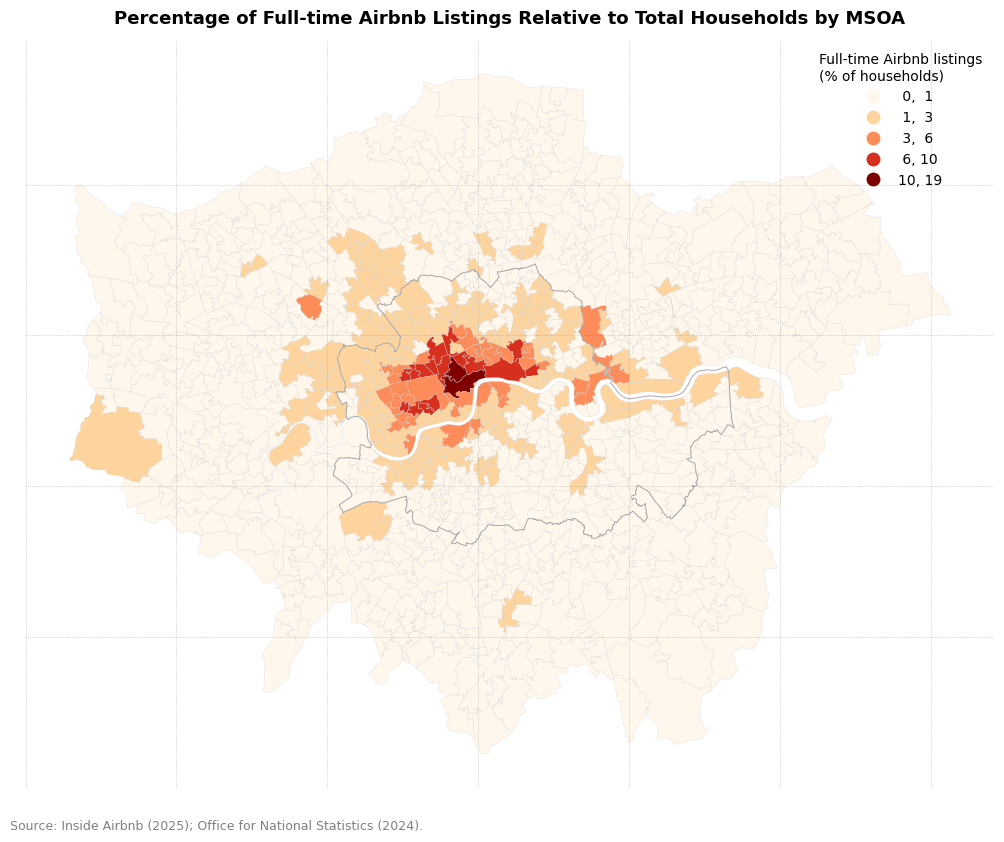

In [34]:
# Step 04: Percentage of full-time listings out of total households by MSOA

# Produce a normalised indicator of Airbnb intensity by calculating the proportion of full-time, entire-home listings relative to the total number of households in each MSOA. #This allows comparison across areas with different population sizes and reveals where Airbnb activity may exert stronger pressure on local housing supply. 

# Count how many listings fall in each MSOA
listing_counts = listings_sjoin.groupby("msoa11nm").size()

# Merge MSOA geometry with household data
msoa_merged = msoa.merge(
    housing,
    left_on="msoa11nm",
    right_on="msoa_name"
)[["msoa_name", "households_2011all_households", "geometry"]]

# Reproject to British National Grid
msoa_merged = msoa_merged.to_crs(epsg=27700)

# Merge listing counts
msoa_merged = msoa_merged.merge(
    listing_counts.reset_index(name="listing_counts"),
    left_on="msoa_name",
    right_on="msoa11nm",
    how="left"
)

# Replace missing listings with 0
msoa_merged["listing_counts"] = msoa_merged["listing_counts"].fillna(0)

# Calculate percentage of Airbnb listings relative to households
msoa_merged["percentage"] = (
    msoa_merged["listing_counts"]
    / msoa_merged["households_2011all_households"]
    * 100
)


# Inner London outline


# Ensure boroughs are in same CRS
borough = borough.to_crs(epsg=27700)

borough_inner = borough[
    borough["district"].isin(inner_london)
].copy()

inner_london_outline = borough_inner.dissolve()
inner_london_outline = inner_london_outline.to_crs(msoa_merged.crs)



# Plot map


fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# MSOA choropleth FIRST
msoa_merged.plot(
    ax=ax,
    column="percentage",
    cmap="OrRd",
    scheme="NaturalBreaks",
    k=5,
    linewidth=0.2,
    edgecolor="lightgrey",
    legend=True,
    legend_kwds={
        "title": "Full-time Airbnb listings\n(% of households)",
        "fmt": "{:.0f}"
    }
)

# Inner London outline ON TOP
inner_london_outline.plot(
    ax=ax,
    facecolor="none",
    edgecolor="darkgrey",
    linewidth=0.7
)



# Real grid (OS National Grid – 5 km)


xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()

grid_spacing = 10000  # 10 km

ax.set_xticks(np.arange(xmin, xmax, grid_spacing))
ax.set_yticks(np.arange(ymin, ymax, grid_spacing))

ax.grid(
    color="grey",
    linestyle=":",
    linewidth=0.5,
    alpha=0.6
)

# Hide tick labels but keep grid
ax.tick_params(
    labelbottom=False,
    labelleft=False,
    bottom=False,
    left=False
)

# Remove outer black frame (axes spines)
for spine in ax.spines.values():
    spine.set_visible(False)



# Clean legend box


leg = ax.get_legend()
leg.get_frame().set_linewidth(0)
leg.get_frame().set_facecolor("none")



# Layout


ax.set_title(
    "Percentage of Full-time Airbnb Listings Relative to Total Households by MSOA",
    fontsize=13,
    fontweight="bold",
    pad=12
)

fig.text(
    0.00, -0.02,
    "Source: Inside Airbnb (2025); Office for National Statistics (2024).",
    ha="left",
    va="top",
    fontsize=9,
    color="grey"
)

plt.tight_layout()
plt.show()


**Summary Figure 02** 
> Conclusions from the map The map reveals a highly asymmetric spatial distribution of illegal Airbnb Activity in London. In contrast, most MSOAs in Outer London, show minimun levels of illegal Airbnb Activity. This suggests that Airbnb is not "out of control" everywhere, but is concentrated in central, high demand areas. (This parragraph needs more work)
> Some of the darkest MSOAs—particularly in the City of London and a few central districts—reflect very high percentages of full-time Airbnb listings relative to local households.
This does not necessarily indicate unusually high Airbnb activity; rather, these areas have very small residential populations and low household counts. These values should therefore be interpreted with caution.

In [35]:
# Step 05: Clean rent dataset (Could this be moved to data cleaning section? is a short code)

# Limitations: 
# We were only able to find current rental information at the borough level, not at the MSOA level.
# As a result, the analysis must be conducted using a larger spatial unit than originally intended. 

rent = rent.replace(["..", "-"], pd.NA)

numeric_cols = ["count_of_rents", "mean", "lower_quartile", "median", "upper_quartile"]

for col in numeric_cols:
    rent[col] = pd.to_numeric(rent[col], errors="coerce")

rent.head(7)

# ---- Output data ----
# rent: the data frame now cleaned

,borough,bedroom_category,count_of_rents,mean,lower_quartile,median,upper_quartile
0,Barking and Dagenham,Room,10.0,514.0,NaN,559.0,NaN
1,Barking and Dagenham,Studio,10.0,892.0,800.0,838.0,981.0
2,Barking and Dagenham,One Bedroom,180.0,1187.0,1050.0,1200.0,1300.0
3,Barking and Dagenham,Two Bedrooms,280.0,1416.0,1250.0,1415.0,1550.0
4,Barking and Dagenham,Three Bedrooms,180.0,1657.0,1500.0,1625.0,1850.0
5,Barking and Dagenham,Four or More Bedrooms,20.0,2112.0,1796.0,2200.0,2500.0
6,Barnet,Room,20.0,682.0,612.0,626.0,676.0


In [36]:
# Step 06: Classify the listings by bedroom category for comparability 
#          with the rental dataset

# This classification allows direct comparison between:
#   - the supply of Airbnb listings by bedroom type, and
#   - the distribution of long-term rental properties by bedroom type.

# It will also enable bedroom-specific analyses of rent gaps .

# Create a function to convert numeric bedroom counts into categorical labels . 
def map_bedroom_category(n):
    if pd.isna(n):
        return "Unknown"
    n = int(n)
    if n <= 0:
        return "Studio"
    elif n == 1:
        return "One Bedroom"
    elif n == 2:
        return "Two Bedrooms"
    elif n == 3:
        return "Three Bedrooms"
    else:
        return "Four or More Bedrooms"

# Apply the classification to the listings dataset
listings_entirehome["bedroom_category"] = listings_entirehome["bedrooms"].apply(map_bedroom_category)

# Review the result
listings_entirehome["bedroom_category"].value_counts()

bedroom_category
One Bedroom              25349
Two Bedrooms             18960
Three Bedrooms            6810
Four or More Bedrooms     3776
Studio                    1933
Unknown                    743
Name: count, dtype: int64

In [37]:
# Step 07: Spatial Join Airbnb revenue estimates by borough shapefile


# Reproject to Britain National Grid
borough_shp = borough_shp.to_crs(epsg=27700)


# Create a subset of listings, with the listings that comply with the conditions to evaluate monthly revenue
# (1) Estimated revenue > 0 - removes listings that are inactive or not generating revenue
# (2) Estimated occupancy 365 > 60 - This threshold removes listings that operate only sporadically or at very low levels of activity. 
#     Filtering them out ensures that the revenue estimates represent listings that are genuinely operating 
#     as part of the short-term rental market and can therefore be compared more meaningfully with long-term rents.

listings_filtered = (
    listings_entirehome[
        (listings_entirehome["estimated_revenue_l365d"] > 0) &
        (listings_entirehome["estimated_occupancy_l365d"] >= 90)  
    ]
).copy()


# Convert into GeoDataFrame
listings_filtered = gpd.GeoDataFrame(
    listings_filtered,
    geometry=gpd.points_from_xy(
        listings_filtered.longitude,
        listings_filtered.latitude
    ),
    crs="EPSG:4326"   # o el CRS original de tus listings
)

# Reproject into British National Grid
listings_filtered = listings_filtered.to_crs(epsg=27700)

# Create estimated monthly revenue (annual revenue divided by 12)
listings_filtered["monthly_revenue"] = listings_filtered["estimated_revenue_l365d"] / 12

#Spatial join: assign each filtered listing to its borough polygon
listings_sjoin = gpd.sjoin(
    listings_filtered,
    borough_shp,
    how="left",
    predicate="within"
)

# Calculate mean monthly revenue by borough and bedroom category
mean_revenue = (
    listings_sjoin
    .groupby(["borough_name", "bedroom_category"])["monthly_revenue"]
    .mean()
    .reset_index()
)

# Convert to wide format (bedroom categories as columns)
mean_revenue_wide = mean_revenue.pivot(
    index="borough_name",
    columns="bedroom_category",
    values="monthly_revenue"
).reset_index()


#Merge revenue table back into the borough shapefile
borough_revenue = borough_shp.merge(
    mean_revenue_wide,
    on="borough_name",
    how="left"
)

# Remove the 'Unknown' bedroom category (not meaningful for comparison)
borough_revenue = borough_revenue.drop(columns=["Unknown"])

# Rename columns for consistency, as we are later adding the revenue of private rent 
borough_revenue = borough_revenue.rename(columns={
    "Studio": "studio_airbnb",
    "One Bedroom": "one_bedroom_airbnb",
    "Two Bedrooms": "two_bedroom_airbnb",
    "Three Bedrooms": "three_bedroom_airbnb",
    "Four or More Bedrooms": "fourplus_airbnb"
})

# Standardise borough name field
borough_revenue = borough_revenue.rename(columns={"borough_name": "borough_clean"})



# Exclude the City of London (we dont have private rental data for this borough)
borough_revenue = borough_revenue[
    ~borough_revenue["borough_clean"] .isin([
        "city and county of the city of london",
        "city of westminster"
    ])
]
borough_revenue.head()

,borough_code,geometry,borough_clean,fourplus_airbnb,one_bedroom_airbnb,studio_airbnb,three_bedroom_airbnb,two_bedroom_airbnb
1,E09000002,"POLYGON ((545714.899 181642.305, 545678.901 18...",barking and dagenham,2404.888889,1706.350000,NaN,1583.083333,1749.674242
2,E09000003,"POLYGON ((523293.197 186457.696, 523239.2 1865...",barnet,3281.563725,1593.494709,1041.705556,2765.093137,2073.707692
3,E09000004,"POLYGON ((547962.296 170556.398, 547957.399 17...",bexley,4904.166667,1195.519841,1280.833333,1539.716667,1150.125000
4,E09000005,"POLYGON ((521058.398 183113.004, 521051.002 18...",brent,3817.236842,2723.144253,1722.090909,3383.306667,2553.541209
5,E09000006,"POLYGON ((540344.998 157603.096, 540339.803 15...",bromley,4367.638889,1485.405556,1721.535714,2278.046296,1635.460145


In [38]:
# Step 08: Merge rent data with the borough shapefile and the 
#    borough-level Airbnb revenue estimates.
 
# Align long-term rental prices with Airbnb  revenue estimates at the borough level.

# Standardise the borough name to ensure a correct merge
rent["borough_clean"] = rent["borough"].str.lower().str.strip()

# Convert to wide format (bedroom categories as columns)
rent_wide = rent.pivot(
    index="borough_clean",
    columns="bedroom_category",
    values="mean"
).reset_index()

# Drop room category, as we are working with entire units
rent_wide = rent_wide.drop(columns=["Room"])

# Rename columns for consistency, 
rent_wide = rent_wide.rename(columns={
    "Studio": "studio_rent",
    "One Bedroom": "one_bedroom_rent",
    "Two Bedrooms": "two_bedroom_rent",
    "Three Bedrooms": "three_bedroom_rent",
    "Four or More Bedrooms": "fourplus_rent"
})

# Merge the rental data with borough-level Airbnb revenue estimates
revenue_airbnb_rent = borough_revenue.merge(
    rent_wide,
    on="borough_clean",
    how="left")


# Identify all numeric columns that should not be strings
cols_to_fix = [
    "studio_rent", "one_bedroom_rent", "two_bedroom_rent",
    "three_bedroom_rent", "fourplus_rent",
    "studio_airbnb", "one_bedroom_airbnb", "two_bedroom_airbnb",
    "three_bedroom_airbnb", "fourplus_airbnb"
]

# Convert all to numeric (strings → numbers, invalid → NaN)
for col in cols_to_fix:
    revenue_airbnb_rent[col] = pd.to_numeric(
        revenue_airbnb_rent[col], errors="coerce"
    )
    
revenue_airbnb_rent.head()

# ---- Output data ----
# revenue_airbnb_rent : Consolidates the two sources or the housing market at a borough scale:
#       (1) estimated Airbnb monthly revenue, disaggregated by bedroom category
#       (2) mean long-term private rental prices, disaggregated by bedroom category
#       This dataset enables direct comparison between the two categories.



,borough_code,geometry,borough_clean,fourplus_airbnb,one_bedroom_airbnb,studio_airbnb,three_bedroom_airbnb,two_bedroom_airbnb,fourplus_rent,one_bedroom_rent,studio_rent,three_bedroom_rent,two_bedroom_rent
0,E09000002,"POLYGON ((545714.899 181642.305, 545678.901 18...",barking and dagenham,2404.888889,1706.350000,NaN,1583.083333,1749.674242,2112.0,1187.0,892.0,1657.0,1416.0
1,E09000003,"POLYGON ((523293.197 186457.696, 523239.2 1865...",barnet,3281.563725,1593.494709,1041.705556,2765.093137,2073.707692,3174.0,1378.0,1062.0,2176.0,1657.0
2,E09000004,"POLYGON ((547962.296 170556.398, 547957.399 17...",bexley,4904.166667,1195.519841,1280.833333,1539.716667,1150.125000,1782.0,1173.0,836.0,1586.0,1397.0
3,E09000005,"POLYGON ((521058.398 183113.004, 521051.002 18...",brent,3817.236842,2723.144253,1722.090909,3383.306667,2553.541209,3150.0,1958.0,1700.0,2525.0,2343.0
4,E09000006,"POLYGON ((540344.998 157603.096, 540339.803 15...",bromley,4367.638889,1485.405556,1721.535714,2278.046296,1635.460145,2619.0,1198.0,968.0,1883.0,1497.0


#### **Figure 03** | Scatterplot Airbnb vs Private Rent Monthly revenue by bedroom category

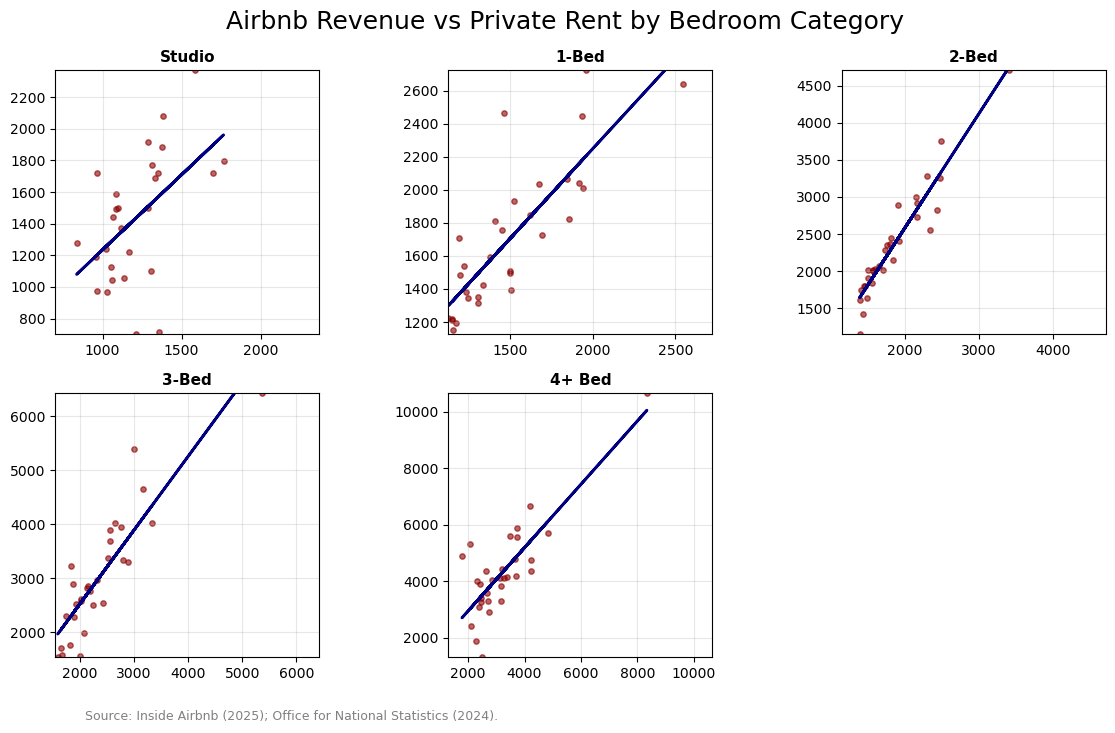

In [39]:
# Step 08: 2x3 Layout (5 plots)
categories = {
    "Studio": ("studio_rent", "studio_airbnb"),
    "1-Bed": ("one_bedroom_rent", "one_bedroom_airbnb"),
    "2-Bed": ("two_bedroom_rent", "two_bedroom_airbnb"),
    "3-Bed": ("three_bedroom_rent", "three_bedroom_airbnb"),
    "4+ Bed": ("fourplus_rent", "fourplus_airbnb")
}

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. 
fig, axes = plt.subplots(2, 3, figsize=(12, 7)) 
axes_flat = axes.flatten()

for i, (cat, (rent_col, airbnb_col)) in enumerate(categories.items()):
    ax = axes_flat[i]
    
    x = pd.to_numeric(revenue_airbnb_rent[rent_col], errors="coerce")
    y = pd.to_numeric(revenue_airbnb_rent[airbnb_col], errors="coerce")

    ax.scatter(x, y, color='#8B0000', s=15, alpha=0.6)

    valid = ~(x.isna() | y.isna())
    x_valid = x[valid]
    y_valid = y[valid]

    if len(x_valid) > 1:
        m, b = np.polyfit(x_valid, y_valid, 1)
        ax.plot(x_valid, m*x_valid + b, color="navy", linewidth=2)

    if len(x_valid) > 0:
        tmin, tmax = min(x_valid.min(), y_valid.min()), max(x_valid.max(), y_valid.max())
        ax.set_xlim(tmin, tmax)
        ax.set_ylim(tmin, tmax)
    
    ax.set_aspect("equal", "box")
    ax.set_title(cat, fontsize=11, fontweight='bold')
    ax.grid(alpha=0.3)

# Credit / source note
fig.text(
    0.1, -0.02,
    "Source: Inside Airbnb (2025); Office for National Statistics (2024).",
    ha="left",
    va="top",
    fontsize=9,
    color="grey"
)

fig.delaxes(axes_flat[5])
plt.suptitle("Airbnb Revenue vs Private Rent by Bedroom Category", fontsize=18)
plt.tight_layout()
plt.show()


# ---- Output figure ----
#  Figure 03: Scatterplot Airbnb Revenue vs Private Rent by Bedroom Category 

**Summary Figure 03** 
>The scatter plots show that while studios and one-bedroom units have similar returns in Airbnb and the private rental market, larger units (2–4+ bedrooms) generate significantly higher Airbnb revenue. This indicates stronger financial incentives to convert family-sized homes into short-term rentals.

In [40]:
#  Calculate the slopes to enable precise comparison between the 5 categories
slopes = {}

for cat, (rent_col, airbnb_col) in categories.items():
    
    # Force numeric (avoid dtype errors)
    x = pd.to_numeric(revenue_airbnb_rent[rent_col], errors="coerce")
    y = pd.to_numeric(revenue_airbnb_rent[airbnb_col], errors="coerce")
    
    valid = ~(x.isna() | y.isna())
    x_valid = x[valid]
    y_valid = y[valid]
    
    # Compute slope only if there are enough points
    if len(x_valid) > 1:
        m, b = np.polyfit(x_valid, y_valid, 1)
        slopes[cat] = m
    else:
        slopes[cat] = np.nan

slopes

{'Studio': np.float64(0.9495216841687982),
 '1-Bed': np.float64(1.0871747891311243),
 '2-Bed': np.float64(1.5430494983622292),
 '3-Bed': np.float64(1.3627966257315078),
 '4+ Bed': np.float64(1.1222977210269596)}

#### **Figure 04** | Rent Gap (Airbnb vs Private Rent) Two Bedroom Units

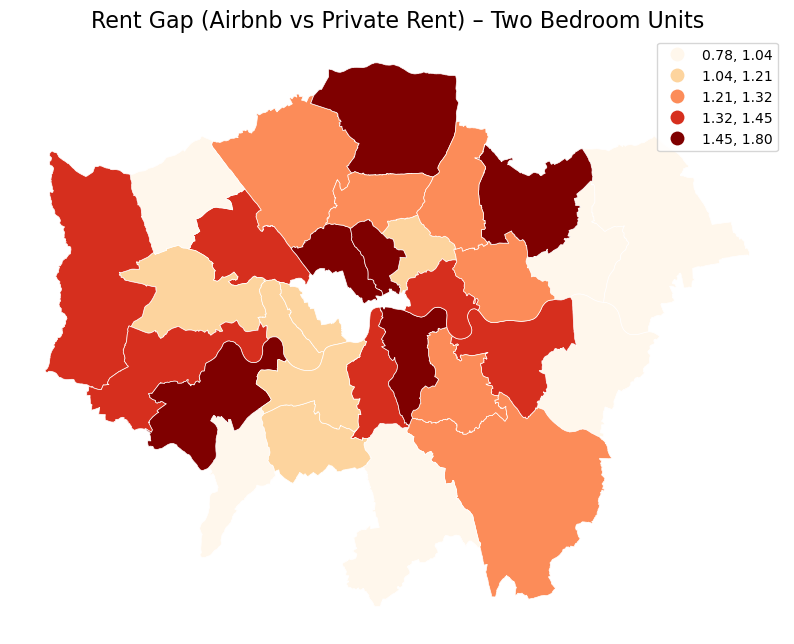

In [41]:
# Step 10: Map the rent gap (Airbnb revenue / private rent) for two-bedroom units 
#    across London boroughs.

# The rent gap is calculated as the ratio between the average monthly
# Airbnb revenue and average private rent for the same unit size.
# Values > 1 indicate that Airbnb is more profitable than renting 
# long-term, revealing boroughs where incentives to convert homes 
# into short-term rentals are strongest.

# Calculate the rent gap for three-bedroom units
revenue_airbnb_rent["rentgap_three_bedroom"] = (
    revenue_airbnb_rent["three_bedroom_airbnb"] /
    revenue_airbnb_rent["three_bedroom_rent"]
)

# Plot the spatial distribution of the rent gap
revenue_airbnb_rent.plot(
    column="rentgap_three_bedroom",
    cmap="OrRd",
    scheme="Quantiles",
    k=5,
    linewidth=0.5,
    edgecolor="white",
    legend=True,
    figsize=(10,10)
)
plt.title("Rent Gap (Airbnb vs Private Rent) – Two Bedroom Units", fontsize=16)
plt.axis("off")
plt.show()

# ---- Output figure ----
#  Figure 04: Cloropeth map of Rent Gap (airbnb vs private rent) in two-bedroom units

**Summary Figure 04** 
> This map shows the spatial distribution of the rent gap—defined as the ratio between Airbnb monthly revenue and private rent—for two-bedroom units across London boroughs. The pattern is concentrated in central and high-demand boroughs, suggesting greater market pressure on family-sized housing in these areas.
> Boroughs are very large areas, and the rent gap can change a lot inside the same borough. So this map shows the general pattern, but not the smaller local differences.

#### **Figure 02** | Rent gap in Camden, by bedroom category

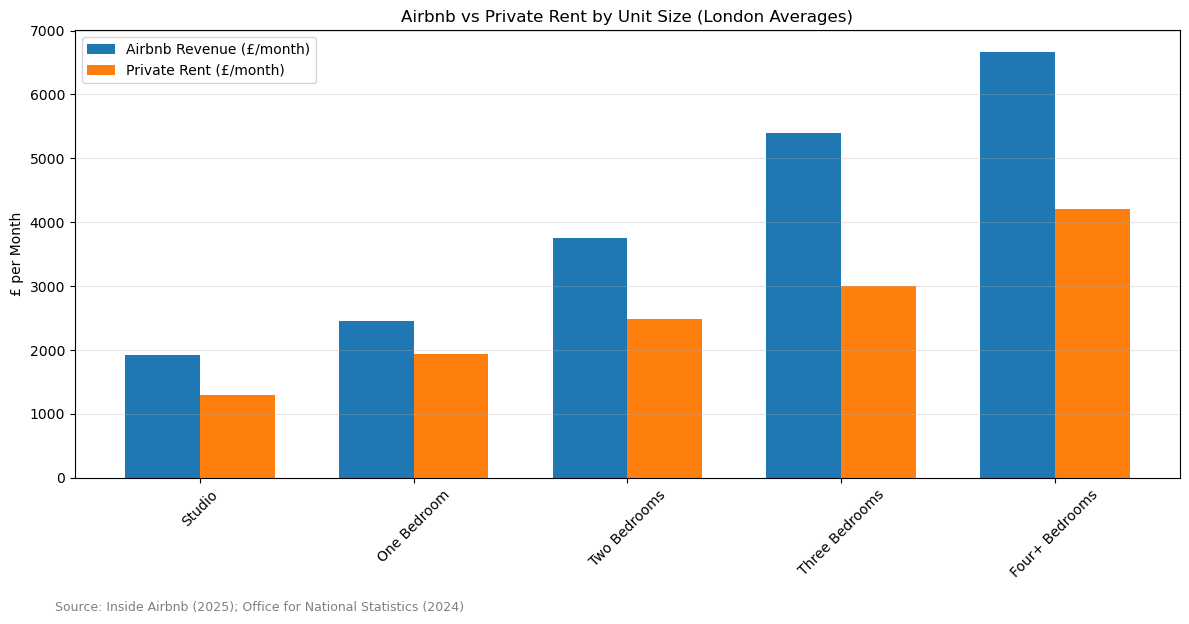

In [48]:
# Step 11: Zoom in on a high-pressure borough, Camden in this case, to compare 
#     Airbnb revenue and private rent by unit size and illustrate 
#     local rent gaps in more detail.


df = revenue_airbnb_rent

# Choose borough
borough = "camden"   # <--- cambia aquí

# Filter borough row
row = df[df["borough_clean"] == borough].iloc[0]

# Tipologías y columnas asociadas
categories = ["Studio", "One Bedroom", "Two Bedrooms", "Three Bedrooms", "Four+ Bedrooms"]

airbnb_cols = [
    "studio_airbnb",
    "one_bedroom_airbnb",
    "two_bedroom_airbnb",
    "three_bedroom_airbnb",
    "fourplus_airbnb"
]

rent_cols = [
    "studio_rent",
    "one_bedroom_rent",
    "two_bedroom_rent",
    "three_bedroom_rent",
    "fourplus_rent"
]

# Extract values for this borough
airbnb_values = row[airbnb_cols].values
rent_values = row[rent_cols].values

# Plot
x = np.arange(len(categories))
width = 0.35

plt.figure(figsize=(12,6))

plt.bar(x - width/2, airbnb_values, width, label="Airbnb Revenue (£/month)")
plt.bar(x + width/2, rent_values, width, label="Private Rent (£/month)")

plt.xticks(x, categories, rotation=45)
plt.ylabel("£ per Month")
plt.title("Airbnb vs Private Rent by Unit Size (London Averages)")
plt.legend()
plt.grid(axis="y", alpha=0.3)

# Credit / source note
credit_text = (
    "Source: Inside Airbnb (2025); Office for National Statistics (2024)"
)

fig = plt.gcf()
fig.text(
    0.05, -0.01,
    credit_text,
    ha="left",
    va="top",
    fontsize=9,
    color="grey"
)


plt.tight_layout()
plt.show()

# ---- Output figure ----
#  Figure 05: Scatterplot Airbnb Revenue vs Private Rent by Bedroom Category 

**Summary Figure 04** 
> In a high demand , center located neighborhood like Camden, Airbnb earns more than private rent across all unit sizes.
>For two-bedroom homes, Airbnb brings in around £1,000 more per month (about +35%).
>For three-bedroom homes, the gap is even larger, Airbnb earns roughly £1,800 extra per month (around +60%).

Under London’s regulatory framework, a property may not be rented out for more than 90 nights a year as short-term rental without applying for a change of use, from residential to temporary acommodation. 

*** it would be good to have an approx stat here on the % of airbnbs that are operating with a temporary accomodation license - presumably almost no listings have this ***

We define short-term rental listings as those which allow a minimum length of stay shorter than 30 nights.
*** It would be great to find a stat here that says x % of airbnbs are used for short term rather than long term rentals to back up our assumptions ***

Although the Inside Airbnb dataset provides calendar data showing the availability of a listing for the next 365 days, it is impossible to assertain whether unavailable nights are as a result of nights being booked out by a guest or nights being 'blacked-out' by the owner. Thus, information on the number of days that listings are being rented out annually is sparse and unreliable. Instead, the following calculation was used to estimate the number of nights that each listing was occupied in the last 12 months:

*** we will make this into a nice equation on quarto***

occupancy in the last 12 months = (number of reviews in the last 12 months)/(percentage of guests that leave reviews)*(average minimum number of nights that guests are able to book for)

Assumptions
- number of reviews in the last 12 months is a proxy for demand (Quattrone SE economy paper & Fradkin 2015)
- 70% of guests leave reviews (Fradkin 2015)
- minimum number of nights is a number inputted by the owner on the app, and this can changed at any time and on a day-to-day basis (based on seasonality, preference,  etc) so might not reflect the situation for the previous 12 months
- Some of calculated last 12 month occupancy was > 365 (possibly because the current minimum number of nights is higher than the true minimum number of nights). We assume that it is plausible to assume 



#### Illegal revenue paragraph

In [ ]:
# -- Methodology: Illegal listings and revenue --
# Steps Overview:
# 1. Create a function to calculate estimated occupancy, revenue illegal and revenue illegal revenue per listing
#        *** Output *** 
#        Stat: Estimated illegal revenue earned in the last year
#        Stat: Percent of illegal revenue from entire homes
# 2. Calculate the number (and %) of hosts that contribute to 50% of total illegal revenue
#        *** Output *** 
#        Stat: Number of hosts contributing to 50% of illegal revenue
# 3. Calculate where majority of the illegal revenue is being generated
#        *** Output *** 
#        Stat: Number of boroughs in which 80% of illegal rebenue is generated, and how much of this is in central london

In [49]:
# ------ Step 1: Function to calculate estimated, occupancy, revenue and illegal revenue under different inputs ------------

def calculate_occupancy_and_revenue(
    df,
    min_cutoff, 
    review_rate, 
    min_stay_buffer,
    max_occupancy):

    """
    Calculate occupancy, total revenue and illegal revenue for each listing.
    """

    # -- Step 1.1 --
    # Create a new dataframe (listings_illegal)
    # subset it to the minimum cutoff
    # listings_illegal is a subset of listings which only includes listings where the minimum minimum nights are < 30 days
    # this is taken as an indicator that the listing is available for short term rentals
    listings_illegal = df[df["minimum_minimum_nights"] < min_cutoff].copy()
    
    # -- Step 1.2 --
    # Calculate estimated occupancy for the last twelve months --> occupancy_ltm
    # We use the minimum_minimum_nights (inputted by the host) here as conservative estimate for the minimum number of days that the listing was occupied in the last 12 months
    # Hosts have general restrictions for the minimum number of nights one can stay at the listing (minimum nights)
    # But these restrictions can be changed by the host so that certain periods have different minimum night restrictions
    # In reality, the number of nights each guest is staying is likely higher than the minimum_minimum_nights
    # This can be controlled by th min_stay_buffer
    listings_illegal["occupancy_ltm"] = (listings_illegal["number_of_reviews_ltm"] / review_rate) * (listings_illegal["minimum_minimum_nights"] + min_stay_buffer)
    
    # Some of the calculated estimated occupancies mayb be very high (with some > 365 which doesn't make sense for an annual estimate)
    # This is likely due to the unreliablitty of 1. number of reviews being a proxy for number of bookings, and 2. minimum_minimum_nights being a proxy for minimum length of stay
    # To account for this, we set a cutoff for the occupancy
    listings_illegal["occupancy_ltm"] = listings_illegal["occupancy_ltm"].clip(upper=max_occupancy)

    # -- Step 1.3 --
    # Calculate estimated annual revenue per listing for the last twelve months
    # It is important to note here that the number of listings without data on price is extremely high
    listings_illegal["revenue_ltm"] = listings_illegal["occupancy_ltm"] * listings_illegal["price"]

    # -- Step 1.4 --
    # Calculate estimated annual illegal revenue per listing (ie only the revenue earned after 90 day limit was exceeded)
    listings_illegal["illegal_revenue_ltm"] = (
    (listings_illegal["occupancy_ltm"] - 90).clip(lower=0)
    * listings_illegal["price"])

    # -- Step 1.5 --
    # Calculating stats
    # Calculating the percentage of illegal listings out of the total
    illegal_rev_count = listings_illegal[listings_illegal["illegal_revenue_ltm"] > 0].shape[0]  # Number of listings for which illegal revenue could be calculated
    rev_count = listings_illegal[listings_illegal["revenue_ltm"] > 0].shape[0]     # Number of listings for with revenue could be calculated
    per_illegal_listings = (illegal_rev_count/rev_count)*100

    # Total illegal airbnb revenue
    illegal_rev_sum = listings_illegal["illegal_revenue_ltm"].sum(skipna=True)

    # Calculating the percentage of illegal listings out of the total
    illegal_rev_for_entire = listings_illegal.loc[
        listings_illegal["room_type"] == 'Entire home/apt',
        'illegal_revenue_ltm'].sum(skipna=True)
    per_illegal_rev_entire = (illegal_rev_for_entire/illegal_rev_sum)*100

    # Other stats (not used but may be relevant)
    # Total number of listings within the subset
    total_count = listings_illegal.shape[0]

    no_reviews = listings_illegal[listings_illegal["number_of_reviews_ltm"] == 0].shape[0]
    # Number of listings for which occupancy could be estimated
    occ_count = listings_illegal[listings_illegal["occupancy_ltm"] > 0].shape[0]

    # Number of listings for which illegal occupancy was calculated
    illegal_occ_count = listings_illegal[listings_illegal["occupancy_ltm"] > 90].shape[0]
    
    # Total airbnb revenue
    rev_sum = listings_illegal["revenue_ltm"].sum(skipna=True)
    
    return listings_illegal, per_illegal_listings, illegal_rev_sum, per_illegal_rev_entire

In [50]:
# ------ Step 2: Function to calculate the proportion of illegal hosts making up 50% of total illegal revenue ------------

def calculate_illegal_host_distribution(listings_illegal):
    """
    Step 2: Calculate the number (and %) of hosts that contribute to 50% of total illegal revenue.
    """

    # -- Step 2.1 --
    # Create a subset for only illegal listings
    listings_illegal_only = listings_illegal[listings_illegal["illegal_revenue_ltm"] > 0].copy()

    # -- Step 2.2 --
    # Group by host ID and calculate each host's illegal revenue
    illegal_revenue_by_host = (
        listings_illegal_only
        .groupby("host_id", as_index=False)
        .agg(
            host_illegal_revenue=("illegal_revenue_ltm", "sum"),
        )
    )
    number_illegal_hosts = illegal_revenue_by_host.shape[0]

    # -- Step 2.3 --
    # Calculate the number of hosts that make up the top 50% of revenue
    sorted_illegal_hosts = illegal_revenue_by_host.sort_values(
        by="host_illegal_revenue", ascending=False
    )

    # -- Step 2.4 --
    # Calculate cumulative sum of illegal revenue
    sorted_illegal_hosts["cum_sum"] = sorted_illegal_hosts["host_illegal_revenue"].cumsum()

    # -- Step 2.5 --
    # Calculate cumulative percentage
    total = sorted_illegal_hosts["host_illegal_revenue"].sum()
    sorted_illegal_hosts["cum_pct"] = sorted_illegal_hosts["cum_sum"] / total

    # -- Step 2.6 --
    # Count how many hosts are needed to reach 50%
    # (+1 ensures we include the host that crosses the threshold)
    num_ill_hosts = (sorted_illegal_hosts["cum_pct"] <= 0.50).sum() + 1

    return number_illegal_hosts, num_ill_hosts

In [51]:
# ------ Step 3: Function to calculate where 80% of illegal revenue is happeneing by borough ------------

def calculate_illegal_revenue_distribution_by_borough(listings_illegal, borough_shp):
    """
    Step 2: Calculate in which boroughs 80% of illegal revenue occurs, and how many of these are in inner london.
    """
    
    # -- Step 3.1 --
    #Convert listings fulltime df into Geopandas

    listings_illegal = gpd.GeoDataFrame(
        listings_illegal,
        geometry=gpd.points_from_xy(
            listings_illegal.longitude,
            listings_illegal.latitude
        ),
        crs="EPSG:4326"
    )
    
    #Reproject to Britain National Grid
    listings_illegal = listings_illegal.to_crs(epsg=27700)

    # -- Step 3.2 --
    # Spatial join of the listing according to borough and create a group count value for each borough
    listings_sjoin = gpd.sjoin(
        listings_illegal,
        borough_shp,
        how="left",
        predicate="within"
    )

    # -- Step 3.3 --
    # Group by borough and calculate the number of illegal listings and their total revenue
    illegal_stats_borough = (
        listings_sjoin
        .groupby("borough_code")
        .agg(
            listing_count=("illegal_revenue_ltm", lambda x: (x > 0).sum()),
            illegal_revenue_sum=("illegal_revenue_ltm", "sum")
        )
        .reset_index()
    )

    # -- Step 3.4 --
    #   Merge the listing_count values (by borough) into the borough GeoDataFrame
    borough_shp_illegal = borough_shp.merge(
        illegal_stats_borough,
        on="borough_code",
        how="left"
    )

    # SAFETY CHECK
    if "illegal_revenue_sum" not in borough_shp_illegal.columns:
        raise ValueError("illegal_revenue_sum column missing after merge.")

    # -- Step 3.5 --
    # Calculate the number of boroughs that make up 80% of illegal revenue
    
    # Sort boroughs by illegal_revenue_sum descending
    sorted_boroughs = borough_shp_illegal.sort_values(
        by="illegal_revenue_sum", ascending=False
    )

    # Calculate cumulative sum of illegal revenue
    sorted_boroughs["cum_sum"] = sorted_boroughs["illegal_revenue_sum"].cumsum()

    # Calculate cumulative percentage
    total = sorted_boroughs["illegal_revenue_sum"].sum()
    sorted_boroughs["cum_pct"] = sorted_boroughs["cum_sum"] / total

    # Count how many boroughs are needed to reach 80%
    num_boroughs_80pct = (sorted_boroughs["cum_pct"] <= 0.80).sum() + 1

    # Check how many of these boroughs are in inner london
    inner_london = [
    "camden",
    "greenwich",
    "hackney",
    "hammersmith and fulham",
    "islington",
    "kensington and chelsea",
    "lambeth",
    "lewisham",
    "southwark",
    "tower hamlets",
    "wandsworth",
    "city of westminster",
    "city of london"
]
    top_boroughs = sorted_boroughs.iloc[:num_boroughs_80pct]["borough_name"].tolist()
    inner_overlap = [b for b in top_boroughs if b in inner_london]
    num_inner_london = len(inner_overlap)
    
    # Return all useful outputs
    return num_boroughs_80pct, num_inner_london

In [52]:
param_sets = [
    {   # SET 1: Conservative estimate
        "min_cutoff": 30, # we are only considering short-term rentals to be those which are rented out for less than 30 days at a time
        "review_rate": 0.70, # We assume that 70% of Airbnb guests leave a review based on the findings of previous studies (Fradkin 2015)
        "min_stay_buffer": 0, # since this is a conservative estimate, we assume that guests which left a review only stayed the minimum number of nights allowed by the host
        "max_occupancy": 292 # we assume a maximum of 80% occupancy for the year
    },
    {   # SET 2: Less conservative estimate
        "min_cutoff": 30,
        "review_rate": 0.60, # fewer people leave reviews (only 60%)
        "min_stay_buffer": 1,  # people stay one night longer than the minimum nights
        "max_occupancy": 292
    }
]

for i, params in enumerate(param_sets, start=1):
    
    # --- Run function 1 (illegal revenue) ---
    listings_illegal, per_illegal_listings, illegal_rev_sum, per_illegal_rev_entire = (
        calculate_occupancy_and_revenue(listings, **params)
    )

    print(f"\n------ Results for parameter set {i} ------")
    print(f"Percent illegal listings out of total: {per_illegal_listings:,.0f}")
    print(f"Total illegal revenue: {illegal_rev_sum:,.0f}")
    print(f"Percentage of illegal revenue from entire home: {per_illegal_rev_entire:,.0f}")

    # --- Run function 2 (illegal revenue distribution among hosts) ---
    number_illegal_hosts, num_ill_hosts = calculate_illegal_host_distribution(listings_illegal)
    
    print(f"Only {(num_ill_hosts/number_illegal_hosts)*100:,.0f}% of hosts involved in illegal Airbnb activity make up 50% of all illegal Airbnb revenue")

    # --- Run function 3 (illegal revenue distribution among boroughs) ---
    num_boroughs_80pct, num_inner_london = calculate_illegal_revenue_distribution_by_borough(listings_illegal, borough_shp)

    print(f"Only {num_boroughs_80pct} boroughs generated 80% of the illegal revenue, {num_inner_london} of which are Inner London boroughs.")


------ Results for parameter set 1 ------
Percent illegal listings out of total: 6
Total illegal revenue: 16,318,482
Percentage of illegal revenue from entire home: 77
Only 6% of hosts involved in illegal Airbnb activity make up 50% of all illegal Airbnb revenue
Only 9 boroughs generated 80% of the illegal revenue, 9 of which are Inner London boroughs.

------ Results for parameter set 2 ------
Percent illegal listings out of total: 18
Total illegal revenue: 83,722,917
Percentage of illegal revenue from entire home: 70
Only 5% of hosts involved in illegal Airbnb activity make up 50% of all illegal Airbnb revenue
Only 9 boroughs generated 80% of the illegal revenue, 9 of which are Inner London boroughs.


**Paragraph for illegal activity**


Under London’s current regulations, a residential property may not be rented out for more than 90 nights per year as a short-term rental without first obtaining planning permission for a “material change of use” from residential to temporary accommodation. We define illegal listings as those which allow short-term rentals (rentals of less than 30 days) and exceed this 90 day limit. 

Highly conservative estimates show that one in every xxx listings is involved in illegal Airbnb activity, with a minimum of £16 million in illegal revenue earned in the last year. More interestingly, xxx

50% of the illegal revenue is attributable to only 171 individual hosts (5% of illegal hosts). Illegal Airbnb activity is mainly localised in the city centre, with 80% of illegal activity occurring in only nine boroughs, all of which are located in the city centre. Although illegal activity generates a significant amount of revenue (and this is likely to be much higher), it is concentrated among a small number of hosts and locations, meaning the overall impact across the city is limited.



## Question 2: How many professional landlords are there?

Following the literature [1], a professional landlord can be defined by making these three assumptions:

- A professional landlord rents entire homes or apartments.
- A professional landlord owns listings with a high availability per year.
- A professional landlord owns more that 1 listings, since managing 2 or more listings requires time and coordination, which makes it unlikely for this to be just a "side-job".

The filter for landlords renting entire homes/apartments and with high availability, so the next step if to filter multi-listers hosts to get the final count of **professional landlords**.

>[1] Shabrina, Z.; Arcaute, E.; Batty, M. (2022), Airbnb and its potential impact on the London housing market, Urban Studies.

#### **Figure 2.1** | Histogram of number of listings per professional host

In [53]:
# Identify the total number of professional hosts
# Filter the multi-listers from listings with high availability per year that are entire homes or apartments  

host_counts = listings_fulltime["host_id"].value_counts()
prof_land = host_counts[host_counts > 1]

print(f"There are {host_counts.count()} in total, and {prof_land.count()} are professional landlords")

# ---- Output Data -----
# Total number of professional landlords
# host_counts = count of the number of listings per landlord
# prof_land = number of professional landlords 

There are 15050 in total, and 3257 are professional landlords


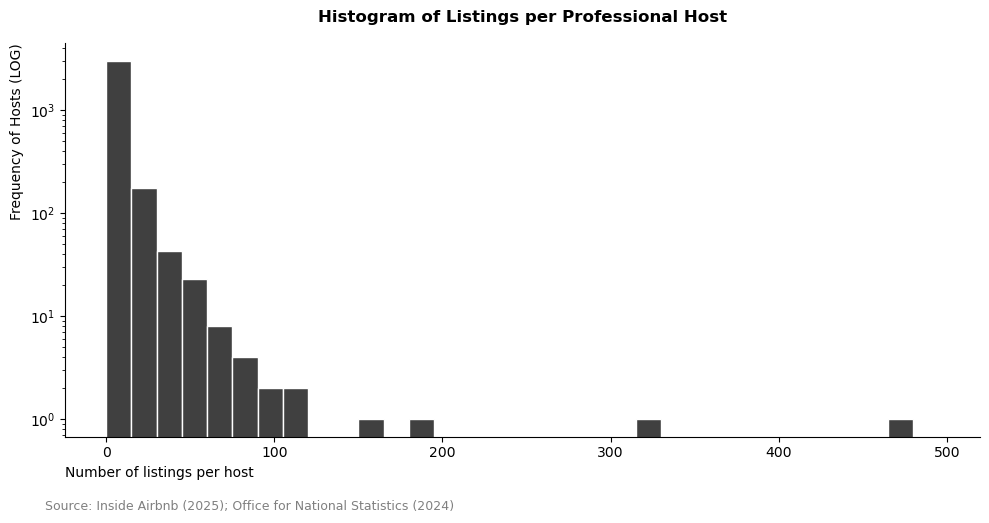

In [56]:
# Create a Histogram explaining the frequency of the number of hosts with the number of listings per host
# Using a log scale for a better visualization 

bins = list(range(0, 500, 15)) #Define bins

plt.figure(figsize=(10,5))

# 1. 
plt.hist(prof_land.values, 
         bins=bins, 
         edgecolor='white', 
         color="#404040") 

plt.yscale('log')

ax = plt.gca() 

ax.spines['top'].set_visible(False) 
ax.spines['right'].set_visible(False) 

# 2. 
ax.set_xlabel("Number of listings per host", 
              loc='left', 
              fontsize=10)
ax.set_ylabel("Frequency of Hosts (LOG)", 
              loc='top', 
              fontsize=10)

# 3. 标
ax.set_title("Histogram of Listings per Professional Host", 
             fontsize=12, fontweight='bold', pad=15)

# 4. 
ax.tick_params(axis='both', labelsize=10)

# Credit / source note
credit_text = (
    "Source: Inside Airbnb (2025); Office for National Statistics (2024)"
)

fig = plt.gcf()
fig.text(
    0.05, -0.01,
    credit_text,
    ha="left",
    va="top",
    fontsize=9,
    color="grey"
)

plt.tight_layout()
plt.show()

# Histogram of the distribution of the number of listings per professional landlord

According to our assumptions, there are **15 050 professional hosts**, and it looks like most of them have less than 100 listings. The hosts with more listings are excepmtions, but it's still important to include them in the analysis since these cases are a signal that the system is, as mentioned before, "out of control"

**Following from the Output:** 

Knowing which ones are the professional landlords would help deepen into finding how do they operate in the system. A way to do this is by:

- Calculating the estimated revenue per host in a year
- Plotting the spatial distribution of the top 6 professional hosts by number of listings.
- Finding if the number of listings per professional host is correlated with being a "superhost"[2], a sign of high-quality service

These outcomes help reveal whether their activity is driven by commercial and profit-oriented practices.

> [2] "What’s required to be a Superhost" (https://www.airbnb.co.uk/help/article/829). Requirements to be a Superhost according to Article:   
> - Experience: At least 10 completed stays (or three stays totalling 100+ nights) which is a sign of consistency  
> - Responsive: Responds quickly to messages (90% response rate) -> a sign of commitment  
> - Three-month criteria: To qualify, these criteria are checked every three months

#### **Figure 2.2** | Distribution of total estimated revenue of professional hosts

In [57]:
# Calculate the amount of revenue per listing in a year
# Extract the professsional landlord from listings_fulltime

prof_ids = prof_land.index 

# Define columns to keep
cols_prof = ['id','host_id','host_is_superhost','estimated_revenue_l365d','geometry']

# Make the filter
listings_prof = listings_fulltime.loc[
    listings_fulltime["host_id"].isin(prof_ids),
    cols_prof].copy()

# Plot
listings_prof

# ---- Output Data -----
# A dataframe with the listings of the professional landlords only and the estimated revenue of each listing per year

,id,host_id,host_is_superhost,estimated_revenue_l365d,geometry
0,264776,1389063,False,32670.0,POINT (537737.328 173423.242)
1,264777,1389063,False,3626.0,POINT (537703.938 173397.858)
2,264778,1389063,False,8140.0,POINT (537508.499 173476.041)
3,264779,1389063,False,9216.0,POINT (537484.993 173470.956)
4,264780,1389063,False,5809.0,POINT (537487.042 173446.529)
...,...,...,...,...,...
96642,1439442552777433600,579958059,True,0.0,POINT (529895.005 177527.768)
96643,1439452993689622016,454626788,False,0.0,POINT (529359.333 183710.551)
96647,1439588527887649792,1190865,True,0.0,POINT (533504.175 184436.027)
96648,1439655439747195648,501629235,False,0.0,POINT (527205.903 181498.693)


In [58]:
# Calculate the amount of revenue per host in one year
# Sum revenue per professional host in pounds £

prof_rev = (listings_prof.groupby("host_id")
    .agg(n_listings=("id", "nunique"),
         is_superhost=("host_is_superhost", "max"),
         total_est_revenue=("estimated_revenue_l365d", "sum")
    )
    .reset_index()
    .sort_values(by="total_est_revenue", ascending=False))

# ---- Output Data -----
# prof_rev: ddataframe including the total revenue per professional landlord

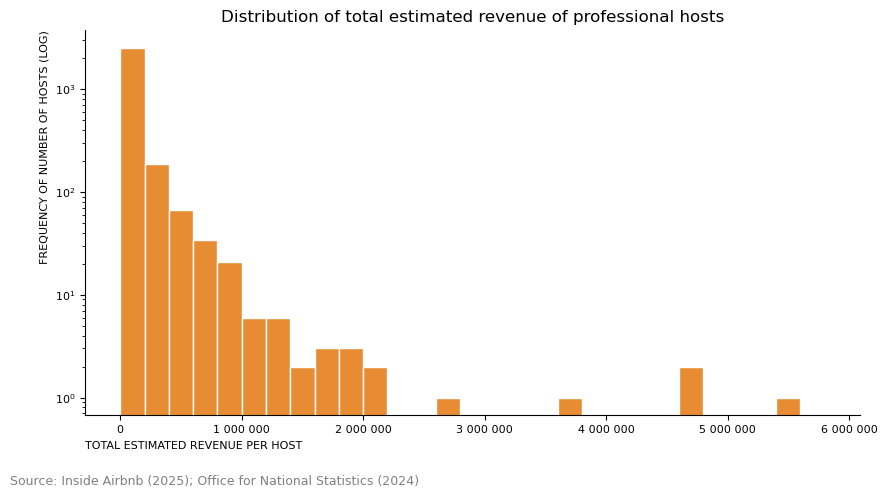

In [60]:
# Histogram explaining the distribution of the total estimated revenue per professional landlord
# Using a log scale for a better visualization 

bins = list(range(0, 6000000, 200000)) #Define bins

plt.figure(figsize=(10,5))

data = prof_rev['total_est_revenue'] #Ignore 0 values
data = data[data > 0]

plt.hist(data.values, 
         bins=bins, 
         edgecolor='white', 
         color="#E78C33")

plt.yscale('log')

ax = plt.gca() #Take tHe current ax

ax.xaxis.set_major_formatter(plt.
    FuncFormatter(lambda x, pos: f"{int(x):,}".
        replace(",", " "))) #Formating the numbers

ax.spines['top'].set_visible(False) #Get rid of innecesarie lines
ax.spines['right'].set_visible(False) #Get rid of innecesarie lines

ax.set_xlabel("TOTAL ESTIMATED REVENUE PER HOST", 
              loc='left', 
              fontsize=8)
ax.set_ylabel("FREQUENCY OF NUMBER OF HOSTS (LOG)", 
              loc='top', 
              fontsize=8)
ax.set_title("Distribution of total estimated revenue of professional hosts")
ax.tick_params(axis='both', labelsize=8) #Fontsize for axis numbers

# Credit / source note
credit_text = (
    "Source: Inside Airbnb (2025)"
)

fig = plt.gcf()
fig.text(
    0.05, -0.01,
    credit_text,
    ha="left",
    va="top",
    fontsize=9,
    color="grey"
)


plt.show()

# ---- Output Data -----
# A histogram of the distributions of the revenues per professional landlord

#### **Figure 2.3** | Spatial distribution of the listings of the top6 professional landlords with the most listings

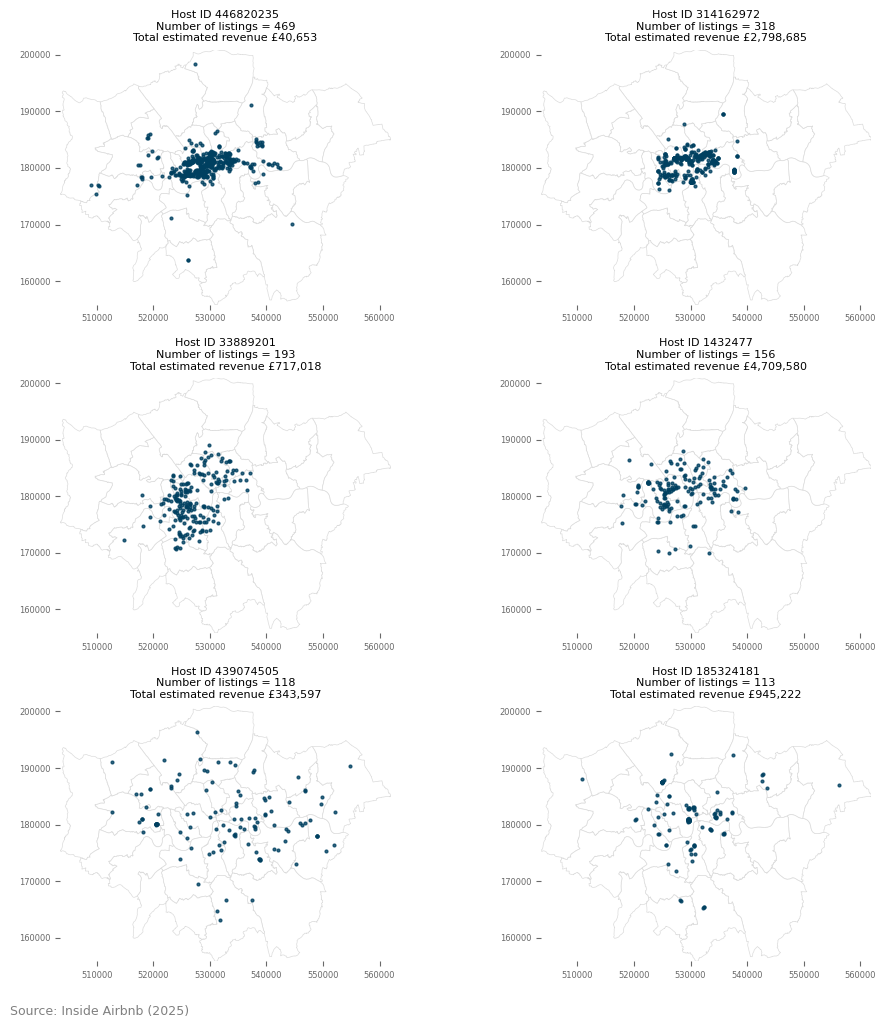

In [62]:
# Plot the spatial distribution of the top 6 professional hosts by number of listings.

# Picking the top 6 professional hosts random hosts to plot
# Keep the information about number of listings and total estimated revenue

prof_top6 = (prof_rev
    .set_index("host_id")
    .sort_values(by="n_listings", ascending=False)
    .head(6)                            
)

#Extract the spatial attributes of the top 10 professional hosts
listings_prof6 = listings_prof[listings_prof["host_id"]
    .isin(prof_top6.index)].copy()

import matplotlib.pyplot as plt
fig, axes = plt.subplots(3, 2, figsize=(10, 10))

# To make sure all the maps share the same frame
xmin, ymin, xmax, ymax = borough_shp.total_bounds

# Loop for each of the top 6 hosts for subplots
for ax, (host_id, row) in zip(axes.flat, prof_top6.iterrows()):
    n_list = row["n_listings"]
    revenue = row["total_est_revenue"]
    
    # subset listings for this host
    sub = listings_prof6[listings_prof6["host_id"] == host_id]

    # Boundaries for context
    borough_shp.plot(
        edgecolor="Gainsboro",
        facecolor="white",
        linewidth=0.5,
        ax=ax
    )
    
    # Listings as points for every host
    sub.plot(
        ax=ax,
        markersize=4,
        color="#004060",
        alpha=0.8,
        legend=False
    )

    ax.set_title(
        f"Host ID {host_id}\n"
        f"Number of listings = {n_list}\n"
        f"Total estimated revenue £{revenue:,.0f}",
        fontsize=8
    )
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    ax.tick_params(axis="both", labelsize=6, color="dimgray", labelcolor="dimgray")

    ax.spines['top'].set_visible(False) #Get rid of innecesarie lines
    ax.spines['bottom'].set_visible(False) #Get rid of innecesarie lines
    ax.spines['right'].set_visible(False) #Get rid of innecesarie lines
    ax.spines['left'].set_visible(False) #Get rid of innecesarie lines

# Credit / source note
credit_text = (
    "Source: Inside Airbnb (2025)"
)

fig = plt.gcf()
fig.text(
    0.05, -0.01,
    credit_text,
    ha="left",
    va="top",
    fontsize=9,
    color="grey"
)

plt.tight_layout()
plt.show()

# ---- Output Data -----
# Spatial distribution of the top 6 professional landlords with the most number of listings

#### **Figure 2.4** | Correlation between the superhost condition and the number of listings

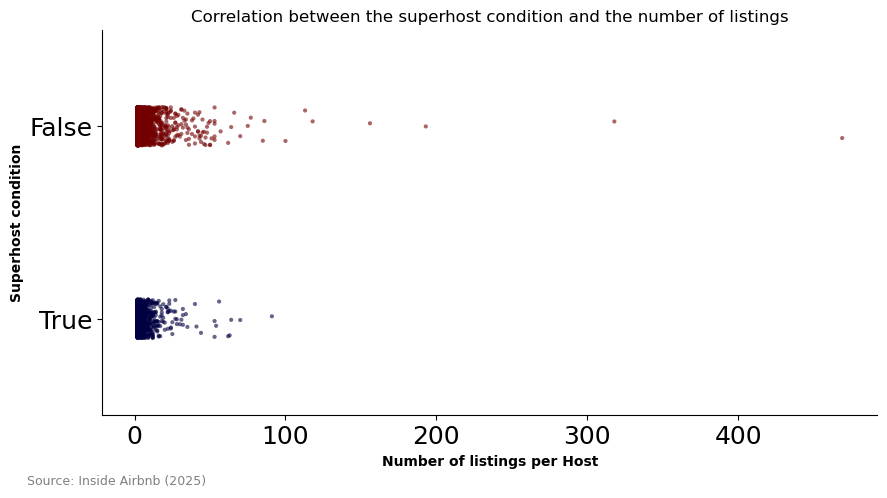

In [65]:
# Finding if the number of listings per professional host is correlated with being a "superhost"
# Create a strip plot

plt.figure(figsize=(10,5))

mi6_palette = {False: "#720000ff", True: "#000042ff"} 

sns.stripplot(
    data=prof_rev,
    x="n_listings",     
    y="is_superhost",    
    hue="is_superhost",
    alpha=0.6,          
    size=3,             
    palette=mi6_palette, 
    orient="h"
)

ax = plt.gca()


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


ax.set_xlabel("Number of listings per Host", loc='center', fontsize=10, fontweight='bold')
ax.set_ylabel("Superhost condition", loc='center', fontsize=10, fontweight='bold')


ax.tick_params(axis='both', labelsize=10)

# Credit / source note
credit_text = (
    "Source: Inside Airbnb (2025)"
)

fig = plt.gcf()
fig.text(
    0.05, -0.01,
    credit_text,
    ha="left",
    va="top",
    fontsize=9,
    color="grey"
)

plt.gca().legend_.remove()
ax.set_title("Correlation between the superhost condition and the number of listings")
ax.tick_params(axis='both', labelsize=18)
# ---- Output Data -----
# A boxplot of the distribution of the the number of listings under the superhost condition per professional landlord

In [66]:
# Calculate Pearson correlation

from scipy.stats import pearsonr

corr_coef, p_value = pearsonr(prof_rev['n_listings'], prof_rev['is_superhost'])
print("Pearson correlation coefficient:", corr_coef)
print("Two-tailed p-value:", p_value)

# ---- Output Data -----
# Pearson's correlation coefficient: two close to zero -> no correlation 
# p-value: lower than 0.05 -> statistically significant

Pearson correlation coefficient: -0.03901317596176325
Two-tailed p-value: 0.02598204375443906


The plots are showing us that the listings of the top 6 professional landlords are spread across London, with some of them being clustered around the central area and in high value boroughs. This spatial distribution, plus the portafolio size and total estimated revenue for all the listings, indicates that some of these hosts are actually comercial operators and not just individuals sharing their houses as the original porpouse of AirBnb was.

In simple terms, our analysis shows that having many Airbnb listings does not mean a host provides better service. This means that having an extensive portfolio does not necessarily indicate higher-quality service, and that the number of listings is more driven by a commercial, and veru profitable as seen in the analysis, business model.

---

#### **Question 3: How many properties would be affected by the opposition’s proposal?**

This question looks at **professional full-time entire-home Airbnb listings only**, attaches each listing to its borough’s and accordingly the average council tax, in order evaluate several listings affected by the oppsional propusal of increasing the council tax, we are applting a **40% council tax increase** as a stndard value of growth (140%) to estimate how many properties see a minor 10% drop in profit.

**The workflow:** clean and merge council tax with borough polygons, use filtered listings, spatially join listings to boroughs, compare average annual revenue vs average council tax by borough, then simulate a 40% tax rise and calculate profit loss per listing before aggregating to borough level.

**Datasets used:** MAYBE MOVE THIS

>**1. Professional landlord listings (from Q2)**
    - Issues:
        - Not all listings have an estimated annual revenue, so they are removed from the calculation.
        - Not all listings are profitable from the beginning, so once subtracting council tax,
      they aren't profitable. And removed from analysis because they have negative values. 

>**2. Borough boundaries (spatial file)**
    - Issues:
        - The boundaries should be deselected and have an output for the actual borough boundary to merge with council tax.

>**3. Borough-level council tax**
    - Issues:
        - The file has been selected by the year 2024-2025 and only filtered to Band D, which the GLA references as a starting point to evaluate the overall borough tax.
        - The value that we extract is associated with the annual tax *(column Band D, which we later rename as council tax).*

In [ ]:
# -- The Work Mythology For evaluating How many properties would be affected by the opposition’s proposal:--
# Steps Overview:
# 1. Cleaning and aligning the Council Tax CSV to prepare for a merge.
# 2. Merge Council Tax Into Borough Shapefile.
# 3. Cleaning and Filtering Listings according to mythology to locate a Professional Landlord, per Q1.
# 4. Spatial Join Listings to Borough Tax Data.
# 5. Calculate Borough Averages: of Airbnb annual Revenue vs Council Tax.
# 6. Evaluate Average Airbnb Revenue vs Average Council Tax per Borough. 
#    Output: Figure 01
# 7. Create a Scenario that increases Council Tax by 40% for Professional Hosts, with the increase varying by borough.
# 8. The borough's share of listings is losing >40% of its profit.
# 9. Linear Relationship Between Revenue and Profit Loss.
#    Output:  **Figure 02** 
# 10. Map of Average Profit Loss per Borough.
#    Output: **Figure 03**

In [67]:
# Step 01 - Cleaning and Aligning Council Tax CSV to prepare for merge

# Rename columns in council tax for easy reading
council_tax2 = council_tax.rename(columns={
    'local_authority': 'borough_name_raw',
    'band_d': 'council_tax',
    'code': 'borough_code'})

# Make sure the borough code is a string
council_tax2['borough_code'] = (
    council_tax2['borough_code']
    .astype(str)
    .str.strip())

# make sure council_tax is numeric, (what was yearly band D)
council_tax2['council_tax'] = pd.to_numeric(council_tax2['council_tax'], errors='coerce')

# drop rows where council_tax is missing value 
council_tax2 = council_tax2.dropna(subset=['council_tax'])

# Print Output of row columns and top 5 head of the rows
print("clean council tax:", council_tax2.shape)
display(council_tax2.head())

# ---- Output Data -----
# council_tax2 = Which is a cleaned and renamed version of council_tax

clean council tax: (33, 3)


,borough_code,borough_name_raw,council_tax
1,E09000001,City of London,1217.89
2,E09000002,Barking & Dagenham,2002.75
3,E09000003,Barnet,1943.24
4,E09000004,Bexley,2155.04
5,E09000005,Brent,2036.05


In [68]:
# Step 02 - Merge Council Tax Into Borough Shapefile

# Merge the shape file borough_shp with council_tax2 through a left join with the borough code value as a shared id
borough_tax = borough_shp.merge(
    council_tax2[['borough_code', 'council_tax']],
    on='borough_code',
    how='left'
)

print("borough_tax merged:", borough_tax.shape)
print("missing council tax:", borough_tax['council_tax'].isna().sum()) # make sure that all boundries have been attributed council tax
display(borough_tax.head())

# ---- Output Data -----
# borough_tax = Merged spatial file with council tax data

borough_tax merged: (33, 4)
missing council tax: 0


,borough_code,geometry,borough_name,council_tax
0,E09000001,"POLYGON ((532715.002 180519.596, 532684.396 18...",city and county of the city of london,1217.89
1,E09000002,"POLYGON ((545714.899 181642.305, 545678.901 18...",barking and dagenham,2002.75
2,E09000003,"POLYGON ((523293.197 186457.696, 523239.2 1865...",barnet,1943.24
3,E09000004,"POLYGON ((547962.296 170556.398, 547957.399 17...",bexley,2155.04
4,E09000005,"POLYGON ((521058.398 183113.004, 521051.002 18...",brent,2036.05


In [69]:
# Step 03 - Use listings_filtered = from Q1
# Using the "Inside Airbnb" estimated model and tagging professional landlords

# Start from Q1 output
listings_q3 = listings_filtered.copy()

# 1. Drop rows with missing IDs (extra safety)
before_id_drop = len(listings_q3)
listings_q3 = listings_q3.dropna(subset=['id', 'host_id'])
after_id_drop = len(listings_q3)
print(f"Removed {before_id_drop - after_id_drop} rows with missing id/host_id")

# 2. Drop rows with missing coordinates
before_coord_drop = len(listings_q3)
listings_q3 = listings_q3.dropna(subset=['latitude', 'longitude'])
after_coord_drop = len(listings_q3)
print(f"Removed {before_coord_drop - after_coord_drop} rows with missing coordinates")

# 3. Create NEW COLUMN: host_is_pro
# Professional landlord = more than 1 listing
listings_q3['host_is_pro'] = listings_q3['host_total_listings_count'] > 1

# 4. Filter to professional landlords only (Q3 requirement)
listings_q3 = listings_q3[
    (listings_q3['host_is_pro'] == True)
].copy()

print("Professional full-time entire homes (estimated model):", listings_q3.shape)
display(listings_q3.head())

# ---- Output ----
# listings_q3 = cleaned + new column + filtered to pros

Removed 0 rows with missing id/host_id
Removed 0 rows with missing coordinates
Professional full-time entire homes (estimated model): (8849, 38)


,id,name,host_id,host_is_superhost,host_total_listings_count,neighbourhood_cleansed,latitude,longitude,property_type,room_type,...,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,estimated_revenue_l365d,estimated_occupancy_l365d,bedroom_category,geometry,monthly_revenue,host_is_pro
0,264776,Huge Four Bedroom Apartment,1389063,False,12,Lewisham,51.44306,-0.01948,Entire rental unit,Entire home/apt,...,11,0,0,0.51,32670.0,110,Four or More Bedrooms,POINT (537737.328 173423.242),2722.500000,True
8,264789,Huge Three Bedroom Flat with parking and terrace,1389063,False,12,Lewisham,51.44346,-0.02122,Entire rental unit,Entire home/apt,...,11,0,0,0.52,26180.0,110,Three Bedrooms,POINT (537615.211 173464.455),2181.666667,True
92,47687,Cosy Double studio in Zone 2 Hammersmith (6),216660,True,11,Hammersmith and Fulham,51.49340,-0.22929,Entire rental unit,Entire home/apt,...,9,1,0,1.18,19890.0,255,One Bedroom,POINT (523021.835 178647.808),1657.500000,True
96,56229,Cosy Double studio in Zone 2 Hammersmith (1),216660,True,11,Hammersmith and Fulham,51.49547,-0.22942,Entire rental unit,Entire home/apt,...,9,1,0,0.94,19890.0,255,One Bedroom,POINT (523007.24 178877.778),1657.500000,True
98,63948,Cosy Double studio in Zone 2 Hammersmith (4),216660,True,11,Hammersmith and Fulham,51.49547,-0.22864,Entire rental unit,Entire home/apt,...,9,1,0,1.25,22695.0,255,One Bedroom,POINT (523061.383 178879.088),1891.250000,True


In [ ]:
listings_q3.columns

In [70]:
# Step 04 - Spatial Join Listings to Borough Tax Data (clean)

# Make sure borough_tax CRS 
borough_tax = borough_tax.to_crs(epsg=4326) 

# Filter listings_fulltime to the London bounding box
# First, calculate the bounding box by maximum and minimum values of the borough boundaries
minx, miny, maxx, maxy = borough_tax.total_bounds

in_london_bbox = (
    (listings_q3['longitude'] >= minx) &
    (listings_q3['longitude'] <= maxx) &
    (listings_q3['latitude']  >= miny) &
    (listings_q3['latitude']  <= maxy)
)

print("full-time listings total:", len(listings_q3))
print("full-time listings inside London bbox:", in_london_bbox.sum())

# make sure all listings point are within the bounding box
listings_london = listings_q3[in_london_bbox].copy()

# Create GeoDataFrame from these listings within the London bounding box
listings_gdf = gpd.GeoDataFrame(
    listings_london.copy(),
    geometry=gpd.points_from_xy(
        listings_london.longitude,
        listings_london.latitude
    ),
    crs="EPSG:4326"
)

# Spatial join using within the same as in the previous methods 
# taking the borough geometry and evaluating which points are within which boroughs, 
# and assigning to each point its borough value and accordingly its annual council tax.
listings_gdf = gpd.sjoin(
    listings_gdf,
    borough_tax[['borough_code', 'borough_name', 'council_tax', 'geometry']],
    how='left',
    predicate='within'
)

print("after spatial join:", listings_gdf.shape)
print("listings missing council tax after join:",
      listings_gdf['council_tax'].isna().sum())

# drop unmatched listings
# points that weren't matched with a borough would be lost
rows_before = listings_gdf.shape[0] 
listings_gdf = listings_gdf.dropna(subset=['council_tax']).copy()
rows_after = listings_gdf.shape[0]
print("dropped unmatched listings:", rows_before - rows_after)
print("after dropping unmatched listings:", listings_gdf.shape)

display(listings_gdf.head())

# Quick visual check
# ax = borough_tax.plot(edgecolor='black', facecolor='none', figsize=(6, 6))
listings_gdf.sample(1000, random_state=1).plot(ax=ax, markersize=1)

# ---- Output Data -----
# listings_london = only points located inside the London Bounding Box
# listing_gdf = geo-dataframe containing listing points and their attributes, boroughs, and council tax.

full-time listings total: 8849
full-time listings inside London bbox: 8849
after spatial join: (8849, 42)
listings missing council tax after join: 0
dropped unmatched listings: 0
after dropping unmatched listings: (8849, 42)


,id,name,host_id,host_is_superhost,host_total_listings_count,neighbourhood_cleansed,latitude,longitude,property_type,room_type,...,estimated_revenue_l365d,estimated_occupancy_l365d,bedroom_category,geometry,monthly_revenue,host_is_pro,index_right,borough_code,borough_name,council_tax
0,264776,Huge Four Bedroom Apartment,1389063,False,12,Lewisham,51.44306,-0.01948,Entire rental unit,Entire home/apt,...,32670.0,110,Four or More Bedrooms,POINT (-0.01948 51.44306),2722.500000,True,22,E09000023,lewisham,2037.98
8,264789,Huge Three Bedroom Flat with parking and terrace,1389063,False,12,Lewisham,51.44346,-0.02122,Entire rental unit,Entire home/apt,...,26180.0,110,Three Bedrooms,POINT (-0.02122 51.44346),2181.666667,True,22,E09000023,lewisham,2037.98
92,47687,Cosy Double studio in Zone 2 Hammersmith (6),216660,True,11,Hammersmith and Fulham,51.49340,-0.22929,Entire rental unit,Entire home/apt,...,19890.0,255,One Bedroom,POINT (-0.22929 51.4934),1657.500000,True,12,E09000013,hammersmith and fulham,1386.77
96,56229,Cosy Double studio in Zone 2 Hammersmith (1),216660,True,11,Hammersmith and Fulham,51.49547,-0.22942,Entire rental unit,Entire home/apt,...,19890.0,255,One Bedroom,POINT (-0.22942 51.49547),1657.500000,True,12,E09000013,hammersmith and fulham,1386.77
98,63948,Cosy Double studio in Zone 2 Hammersmith (4),216660,True,11,Hammersmith and Fulham,51.49547,-0.22864,Entire rental unit,Entire home/apt,...,22695.0,255,One Bedroom,POINT (-0.22864 51.49547),1891.250000,True,12,E09000013,hammersmith and fulham,1386.77


<Axes: title={'center': 'Correlation between the superhost condition and the number of listings'}, xlabel='Number of listings per Host', ylabel='Superhost condition'>

In [ ]:
listings_gdf.columns

In [71]:
# Step 05 -  Borough Averages: Revenue vs Council Tax

# Create a Copy of the file just for this Summary (Safety Reasons)
listings_gdf = listings_gdf.to_crs(epsg=27700) 

listings_for_summary = listings_gdf.copy()

# Group the listings by Borough, calculate new values for the number of listings per borough, Average annual revenue, and average council tax per borough. 
borough_summary = (
    listings_for_summary
    .groupby(['borough_code', 'borough_name'], as_index=False)
    .agg(
        avg_airbnb_revenue=('estimated_revenue_l365d', 'mean'),  # average revenue
        avg_council_tax=('council_tax', 'mean'),        # average council tax
        n_listings=('id', 'count')                      # number of listings
    )
    .sort_values('avg_airbnb_revenue', ascending=False) # affects the plot
)

print("borough_summary shape:", borough_summary.shape)
display(borough_summary.head())


# ---- Output Data -----
# borough_summary = is a summarized table of revenue,tax, and listing per borough.

borough_summary shape: (33, 5)


,borough_code,borough_name,avg_airbnb_revenue,avg_council_tax,n_listings
32,E09000033,city of westminster,53588.010466,975.02,1911
19,E09000020,kensington and chelsea,50181.513889,1529.85,936
0,E09000001,city and county of the city of london,45855.135802,1217.89,81
6,E09000007,camden,40172.577699,2010.87,843
27,E09000028,southwark,34271.364303,1792.98,409


#### **Figure 01** | Average Airbnb Revenue vs Average Council Tax per Borough 

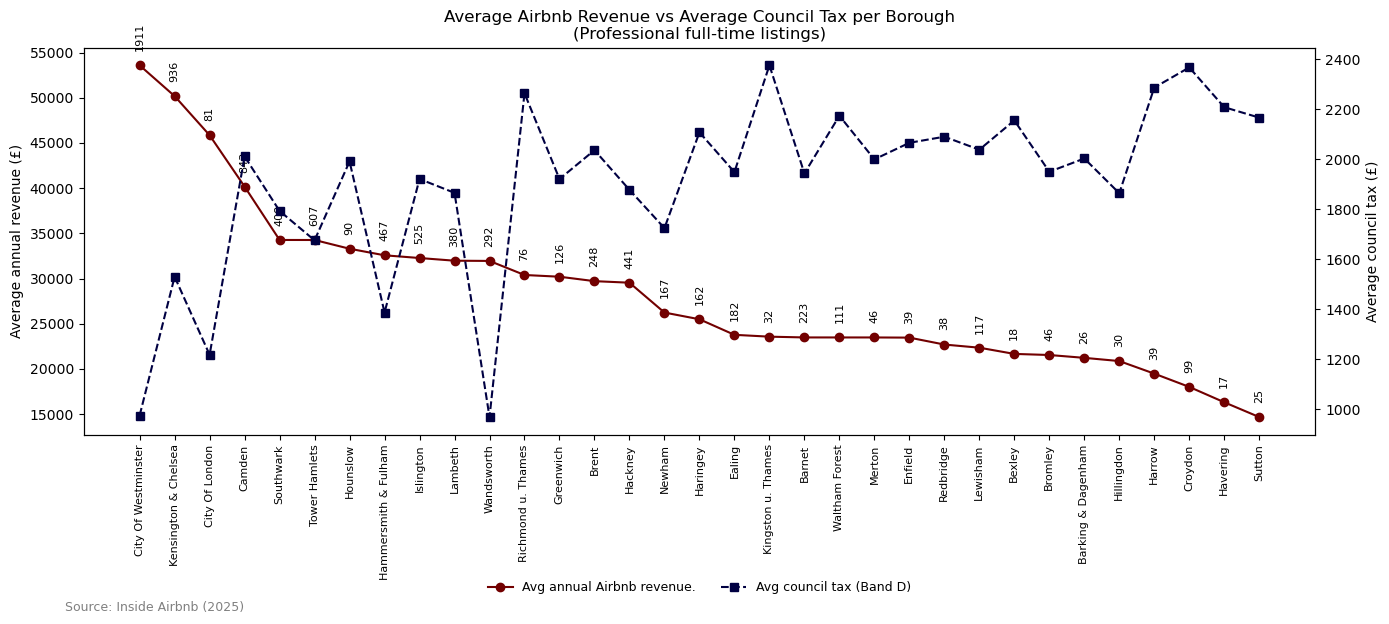

In [83]:
# Step 06 - Figure 01
# A combined line and point graph comparing:
#   (1) Average annual Airbnb revenue per borough
#   (2) Average council tax per borough (Band D)
#   (3) Number of professional full-time listings per borough 
# The x-axis is ordered by borough_summary (currently sorted by number of listings).

# Prep the x-axis labels and positions
# Convert borough names to Title for neat labels.
x_labels = borough_summary['borough_name'].str.title().tolist()

short_labels = [
    lbl.replace(" And ", " & ")
       .replace("Royal Borough Of ", "")
       .replace("City & County Of The ", "")
       .replace(" Upon ", " u. ")
    for lbl in x_labels
]

# Create a numeric position for each borough on the x-axis.
x_pos = np.arange(len(x_labels))

# Extract the series we want to plot from the summary table:
rev_vals = borough_summary['avg_airbnb_revenue'].values   # average annual revenue per borough
tax_vals = borough_summary['avg_council_tax'].values      # average council tax per borough
n_vals   = borough_summary['n_listings'].values           # number of listings per borough

# Create the base figure and first axis (for revenue)
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot Line 1: Average Airbnb revenue per borough (left y-axis)
rev_line = ax1.plot(
    x_pos,
    rev_vals,
    marker='o',
    color="#720000",
    label='Avg annual Airbnb revenue.'
)[0]

# Label the left y-axis for revenue and set the borough names on the x-axis.
ax1.set_ylabel('Average annual revenue (£)')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(short_labels, rotation=90, fontsize=8)

# Create the second axis (for council tax) sharing the same x-axis
ax2 = ax1.twinx()

# Plot Line 2: Average council tax per borough (right y-axis)
tax_line = ax2.plot(
    x_pos,
    tax_vals,
    marker='s',
    linestyle='--',
    color="#000042",
    label='Avg council tax (Band D)'
)[0]

# Label the right y-axis for council tax.
ax2.set_ylabel('Average council tax (£)')

# Add the number of listings as text labels above the revenue points
# Calculate a small vertical offset so the labels sit just above the revenue markers.
offset = (rev_vals.max() - rev_vals.min()) * 0.04  # 4% off the revenue range

for x, y, n in zip(x_pos, rev_vals, n_vals):
    ax1.text(
        x,
        y + offset,
        str(n),            # show the count of listings
        ha='center',
        va='bottom',
        fontsize=8,
        rotation=90
    )

# Combined legend for both lines
ax1.legend(
    [rev_line, tax_line],
    ['Avg annual Airbnb revenue', 'Avg council tax (Band D)'],
    loc='upper right'
)


# Combined legend placed above plot
lines = [rev_line, tax_line]
labels = [l.get_label() for l in lines]

ax1.legend(
    lines,
    labels,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.35),
    ncol=2,
    frameon=False,
    fontsize=9
)

# Layout fix
plt.tight_layout(rect=[0, 0, 1, 0.88])

# Final layout and title 
plt.title(
    'Average Airbnb Revenue vs Average Council Tax per Borough\n'
    '(Professional full-time listings)'
)

# Credit / source note
credit_text = (
    "Source: Inside Airbnb (2025) and London DataStore (2022)"
)

fig = plt.gcf()
fig.text(
    0.05, -0.01,
    credit_text,
    ha="left",
    va="top",
    fontsize=9,
    color="grey"
)
plt.tight_layout()
plt.show()

# ---- Output Figure ----
# Figure 01: Dual-axis line graph showing how average Airbnb revenue and average council tax
#            vary by borough, with listing counts labelled above each revenue point.

In [84]:
# Step 06b - Text Summary for Figure 01
# A short summary of:
#   (1) Average annual revenue per borough
#   (2) Average council tax per borough
#   (3) Top / bottom revenue boroughs
#   (4) Correlation between revenue and council tax

# Ensure we use the same ordering as Figure 01 (highest to lowest revenue)
borough_summary_rev = (
    borough_summary
    .sort_values('avg_airbnb_revenue', ascending=False)
    .reset_index(drop=True)
)

# 1. Overall averages across all boroughs
overall_rev_mean = borough_summary_rev['avg_airbnb_revenue'].mean()
overall_tax_mean = borough_summary_rev['avg_council_tax'].mean()

# 2. Top 3 and bottom 3 boroughs by average annual revenue
top3 = borough_summary_rev.head(3)
bottom3 = borough_summary_rev.tail(3)

# 3. Simple Pearson correlation between revenue and council tax
#    (Measures whether high-tax boroughs also tend to have high average revenue.)
corr_rev_tax = borough_summary_rev['avg_airbnb_revenue'].corr(
    borough_summary_rev['avg_council_tax']
)

print("!! Summary for Figure 01: Revenue vs Council Tax by Borough !!\n")

# Overall averages
print(f"Overall average annual revenue per listing: £{overall_rev_mean:,.0f}")
print(f"Overall average council tax (Band D):      £{overall_tax_mean:,.0f}\n")

# Top 3 revenue boroughs
print("Top 3 boroughs by average annual Airbnb revenue:")
for _, row in top3.iterrows():
    print(
        f"  - {row['borough_name'].title()}: "
        f"£{row['avg_airbnb_revenue']:,.0f} avg revenue, "
        f"£{row['avg_council_tax']:,.0f} avg council tax, "
        f"{int(row['n_listings'])} listings"
    )

# Bottom 3 revenue boroughs
print("\nBottom 3 boroughs by average annual Airbnb revenue:")
for _, row in bottom3.iterrows():
    print(
        f"  - {row['borough_name'].title()}: "
        f"£{row['avg_airbnb_revenue']:,.0f} avg revenue, "
        f"£{row['avg_council_tax']:,.0f} avg council tax, "
        f"{int(row['n_listings'])} listings"
    )

# The relationship between revenue and tax
print("\nCorrelation between average revenue and average council tax:")
print(
    f"  Pearson r ≈ {corr_rev_tax:.2f}  "
    "(+1 = strong positive, 0 = no linear relationship, -1 = strong negative)"
)

!! Summary for Figure 01: Revenue vs Council Tax by Borough !!

Overall average annual revenue per listing: £28,249
Overall average council tax (Band D):      £1,906

Top 3 boroughs by average annual Airbnb revenue:
  - City Of Westminster: £53,588 avg revenue, £975 avg council tax, 1911 listings
  - Kensington And Chelsea: £50,182 avg revenue, £1,530 avg council tax, 936 listings
  - City And County Of The City Of London: £45,855 avg revenue, £1,218 avg council tax, 81 listings

Bottom 3 boroughs by average annual Airbnb revenue:
  - Croydon: £18,019 avg revenue, £2,367 avg council tax, 99 listings
  - Havering: £16,320 avg revenue, £2,208 avg council tax, 17 listings
  - Sutton: £14,684 avg revenue, £2,166 avg council tax, 25 listings

Correlation between average revenue and average council tax:
  Pearson r ≈ -0.72  (+1 = strong positive, 0 = no linear relationship, -1 = strong negative)


**Summary Figure 01** 
> Average Airbnb revenue is much higher than council tax (≈ £28k vs ≈ £1.9k). The map shows a clear mismatch: the highest-earning boroughs (Westminster, Kensington & Chelsea, City of London) pay some of the lowest council taxes, while outer boroughs with weak Airbnb income face higher council tax and very few listings. In short, Airbnb profitability is concentrated in the centre, and council tax has almost no bite where the profits are highest.

In [ ]:
listings_prof.sum['annual_reveue']

In [85]:
# Step 07 - Council Tax Increase Scenario for Professional Hosts
# In this step, we:
#   1) Compute current net profit (revenue - council tax).
#   2) Apply a +140% council tax scenario.
#   3) Measure how much profit each listing loses in % terms.
#   4) Flag listings that lose more than a chosen threshold (e.g. 10%).

# Filter only professional full-time entire homes.
# (All subsequent calculations are done only on this group.)
listings_prof = listings_gdf[listings_gdf['host_is_pro']].copy()
print("Number of professional full-time listings:", listings_prof.shape)

# Make sure the key numeric columns are actually numeric.
# This protects us from strings, blanks, etc.
listings_prof['annual_revenue'] = pd.to_numeric(
    listings_prof['estimated_revenue_l365d'], errors='coerce'
)
listings_prof['council_tax'] = pd.to_numeric(
    listings_prof['council_tax'], errors='coerce'
)

# Drop rows that are missing revenue or council tax and print the outcome
before_na = len(listings_prof)
listings_prof = listings_prof.dropna(subset=['annual_revenue', 'council_tax']).copy()
print("  - Dropped due to missing annual_revenue/council_tax:",
      before_na - len(listings_prof),
      "| remaining:", len(listings_prof))

# ------------------------------------------------------------
# # Current vs increased council tax
# ------------------------------------------------------------

# Current net profit for each listing:
# net_profit_current = annual_revenue - current council tax.
listings_prof['net_profit_current'] = (
    listings_prof['annual_revenue'] - listings_prof['council_tax'])

# Drop listings that are already not profitable BEFORE the tax rise.
# These are not really 'damaged' by the new policy because they were
# not making money to begin with.
before_profit = len(listings_prof)
listings_prof = listings_prof[listings_prof['net_profit_current'] > 0].copy()
print("  - Dropped due to non-positive profit:",
      before_profit - len(listings_prof),
      "| remaining:", len(listings_prof))

# Apply the policy: increase council tax by 140%.
# (Change tax_increase_factor if you want to test another scenario.)
tax_increase_factor = 1.4   # + 40% council tax
listings_prof['council_tax_new'] = listings_prof['council_tax'] * tax_increase_factor

# Net profit AFTER the tax increase:
listings_prof['net_profit_new'] = (
    listings_prof['annual_revenue'] - listings_prof['council_tax_new'])

# Absolute loss in profit in £:
listings_prof['profit_loss_abs'] = (
    listings_prof['net_profit_current'] - listings_prof['net_profit_new'])

# Percentage loss in profit relative to original profit:
listings_prof['profit_loss_pct'] = (
    listings_prof['profit_loss_abs'] / listings_prof['net_profit_current'])

# Total number of listings in our profit model (after all filters above)
n_total_prof = len(listings_prof)

# ------------------------------------------------------------
# Threshold-based loss flag (easily changeable)
# ------------------------------------------------------------

# Choose the policy threshold:
# loss_threshold = 0.1  > loses more than 20% of its original profit.
loss_threshold = 0.1 

# Flag listings that lose more than this % of their original profit.
listings_prof['loss_over_threshold'] = (
    listings_prof['profit_loss_pct'] > loss_threshold
)

# Count how many professional listings are heavily affected.
n_affected = listings_prof['loss_over_threshold'].sum()

# Share of professional listings that lose more than the threshold.
pct_affected = (n_affected / n_total_prof * 100) if n_total_prof > 0 else np.nan

print(
    f"Listings losing more than {loss_threshold:.0%} of profit: "
    f"{n_affected} out of {n_total_prof} "
    f"({pct_affected:.1f}% of professional full-time listings)"
)

# Easy subset for mapping/plotting later on:
# listings_prof_affected contains only the 'heavily hit' listings.
listings_prof_affected = listings_prof[listings_prof['loss_over_threshold']].copy()

# Quick peek at the first few records used in the profit model.
display(
    listings_prof[
        ['borough_name', 'annual_revenue', 'council_tax', 'council_tax_new',
         'net_profit_current', 'net_profit_new',
         'profit_loss_pct', 'loss_over_threshold']
    ].head()
)

# ---- Output DataFrames ----
# listings_prof:
#   Professional full-time entire-home listings that:
#     - have valid annual_revenue and council_tax

# listings_prof_affected:
#   Subset of listings_prof where loss_over_threshold == True.
#   These are the “hit” professional listings that lose
#   more than 40% of their original profit under the new council tax.

Number of professional full-time listings: (8849, 42)
  - Dropped due to missing annual_revenue/council_tax: 0 | remaining: 8849
  - Dropped due to non-positive profit: 0 | remaining: 8849
Listings losing more than 10% of profit: 272 out of 8849 (3.1% of professional full-time listings)


,borough_name,annual_revenue,council_tax,council_tax_new,net_profit_current,net_profit_new,profit_loss_pct,loss_over_threshold
0,lewisham,32670.0,2037.98,2853.172,30632.02,29816.828,0.026612,False
8,lewisham,26180.0,2037.98,2853.172,24142.02,23326.828,0.033767,False
92,hammersmith and fulham,19890.0,1386.77,1941.478,18503.23,17948.522,0.029979,False
96,hammersmith and fulham,19890.0,1386.77,1941.478,18503.23,17948.522,0.029979,False
98,hammersmith and fulham,22695.0,1386.77,1941.478,21308.23,20753.522,0.026033,False


In [86]:
# Step 09 - Borough share of listings losing >10% of profit
# Goal:
#   1) For each borough, count how many professional full-time listings
#      lose more than 10% of their original profit.
#   2) Express this as a percentage of all professional listings
#      in that borough.
#   3) This shows where hosts are *most likely* to be heavily hit
#      by the 40% council tax increase.

# Create a boolean flag for "heavily affected" listings
listings_prof['over_thresh'] = listings_prof['profit_loss_pct'] > loss_threshold

# Borough-level summary of exposure to the policy
borough_impact = (
    listings_prof
    .groupby('borough_name', as_index=False)
    .agg(
        total_listings=('id', 'count'),      # all professional full-time listings
        affected=('over_thresh', 'sum')          # how many lose >10% profit
    )
)

# Convert to percentage of listings in each borough
borough_impact['affected_share_pct'] = (
    borough_impact['affected'] / borough_impact['total_listings'] * 100
).round(1)

# Sort from most exposed borough to least
borough_impact = (
    borough_impact
    .sort_values('affected_share_pct', ascending=False)
    .reset_index(drop=True)
)

display(borough_impact)

# ---- Output table ----
# borough_impact = for each borough:
#   - total_listings: number of professional full-time listings
#   - affected: number of those losing >10% of profit
#   - affected_share_pct: % of listings in that borough that are heavily hit

,borough_name,total_listings,affected,affected_share_pct
0,havering,17,6,35.3
1,bexley,18,5,27.8
2,sutton,25,6,24.0
3,croydon,99,23,23.2
4,hillingdon,30,6,20.0
5,redbridge,38,6,15.8
6,waltham forest,111,17,15.3
7,harrow,39,5,12.8
8,brent,248,29,11.7
9,ealing,182,21,11.5


#### **Figure 02** | Linear Relationship Between Revenue and Profit Loss

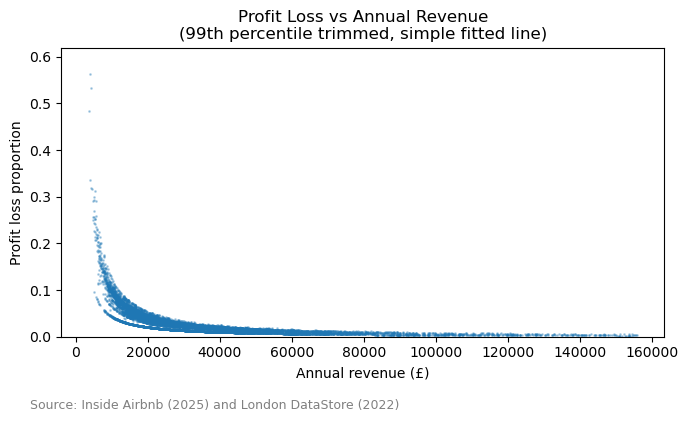

<Figure size 640x480 with 0 Axes>

In [95]:
# Step 09 - Figure 02: Linear Relationship Between Revenue and Profit Loss
# In this step we:
# Trim extremes so a few huge listings don't dominate the axes
rev_q99 = listings_prof['annual_revenue'].quantile(0.99)

# Keep only:
#   - Revenue below or equal to the 99th percentile
#   - Profit loss between 0 and 1 (0–100%)
mask = (
    (listings_prof['annual_revenue'] <= rev_q99) &
    (listings_prof['profit_loss_pct'] >= 0) &
    (listings_prof['profit_loss_pct'] <= 1)   # 0–100% loss
)

# Extract the x (revenue) and y (loss proportion) for the filtered sample
x = listings_prof.loc[mask, 'annual_revenue'].values
y = listings_prof.loc[mask, 'profit_loss_pct'].values

num_used = mask.sum()
num_total = len(listings_prof)
regression_text = "Not enough data for regression." # Default text

# Safety check: only fit a line if we actually have data left
if len(x) > 1:
    # Fit a simple linear regression
    intercept, slope = np.polyfit(x, y, 1)

    # Plot the scatter and the fitted line
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.scatter(x, y, s=1, alpha=0.3)
    x_line = np.linspace(x.min(), x.max(), 100)
    ax.plot(x_line, intercept + slope * x_line, linewidth=2)
    ax.set_xlabel('Annual revenue (£)')
    ax.set_ylabel('Profit loss proportion')
    ax.set_title(
        'Profit Loss vs Annual Revenue\n'
        '(99th percentile trimmed, simple fitted line)'
    )
    ax.set_ylim(0, max(y.max() * 1.1, 0.5))

# Credit / source note
credit_text = (
    "Source: Inside Airbnb (2025) and London DataStore (2022)"
)

fig = plt.gcf()
fig.text(
    0.05, -0.01,
    credit_text,
    ha="left",
    va="top",
    fontsize=9,
    color="grey"
)
plt.tight_layout()
plt.show()
    
 plt.tight_layout()

**Summary Figure 02** 
>Low-earning listings get hit with the opposition proposal. And high-earning listings aren't affected.
>When revenue is small, a 40% tax increase can wipe out a big chunk of profit — sometimes almost all of it.
But once revenue rises, council tax becomes tiny in comparison, so the profit loss drops close to zero.

#### **Figure 03** | Map of Average Profit Loss per Borough

In [105]:
# Step 10 - Average Profit Loss per Borough: Table + Map
#
# Steps:
# Uses the listing-level results from Step 08 (listings_prof with profit_loss_pct).
# Aggregates to the borough level
# Joins those borough-level averages back onto the borough polygons.
# Draws a choropleth map + prints the average % loss on each borough.


# Clip profit_loss_pct to a sensible 0–100% range (0–1 as proportion)
# Avoids weird extreme values dominating the averages.
listings_prof['profit_loss_pct_clipped'] = (
    listings_prof['profit_loss_pct'].clip(lower=0, upper=1)
)

# Borough-level summary of how effective the policy is (on average)
borough_loss_table = (
    listings_prof
    .groupby('borough_name', as_index=False)
    .agg(
        n_listings=('id', 'count'),                         # sample size in borough
        avg_loss_pct=('profit_loss_pct_clipped', 'mean'),   # average loss
        median_loss_pct=('profit_loss_pct_clipped', 'median')  # median loss
    )
)

# Convert proportions to percentages and tidy names
borough_loss_table['avg_loss_pct'] = (
    borough_loss_table['avg_loss_pct'] * 100
).round(1)

borough_loss_table['median_loss_pct'] = (
    borough_loss_table['median_loss_pct'] * 100
).round(1)

borough_loss_table = (
    borough_loss_table
    .rename(columns={
        'borough_name': 'Borough',
        'n_listings': 'Number of professional full-time listings',
        'avg_loss_pct': 'Average profit loss (%)',
        'median_loss_pct': 'Median profit loss (%)'
    })
    .sort_values('Average profit loss (%)', ascending=False)
    .reset_index(drop=True)
)

display(borough_loss_table)

# Join borough polygons to the borough loss table for mapping
borough_loss_map = borough_tax.merge(
    borough_loss_table,
    left_on='borough_name',   # from borough_tax
    right_on='Borough',       # from borough_loss_table
    how='left'
)

# Create a clean column name to plot
borough_loss_map['avg_loss_pct_percent'] = borough_loss_map['Average profit loss (%)']

fig, ax = plt.subplots(figsize=(6, 6))

# Check the actual range of average % loss across boroughs
vmin = borough_loss_table['avg_loss_pct_percent'].min()
vmax = borough_loss_table['avg_loss_pct_percent'].max()

print(f"Range of average loss: {vmin:.1f}% – {vmax:.1f}%")

# Draw the choropleth using the real data range 
gdf.plot(
    column='avg_loss_pct_percent',
    cmap='YlOrRd',      
    linewidth=0.5,
    edgecolor='black',
    legend=True,
    vmin=vmin,
    vmax=vmax,
    ax=ax
)

ax.set_axis_off()
ax.set_title(
    "Average Profit Loss per Borough (%)\n"
    "(Professional full-time, +40% council tax)",
    fontsize=11
)

# Add % labels at borough centroids
centroids = gdf.geometry.centroid

for (_, row), point in zip(gdf.iterrows(), centroids):
    if pd.isna(row['avg_loss_pct_percent']):
        continue
    ax.text(
        point.x,
        point.y,
        f"{row['avg_loss_pct_percent']:.0f}%",  # round to whole % for readability
        ha='center',
        va='center',
        fontsize=6,
        color='black'
    )

plt.tight_layout()
plt.show()

# ---- Output Figure ----
# Figure 03: Choropleth map where each borough is shaded by its average

In [108]:
\n

KeyError: 'Avg Loss %'

**Summary Figure 03** 
> we can see that average profit loss per borough ranges from about **1–5% in central boroughs** up to **10% in some outer boroughs**, meaning outer hosts are more affected by the opposition suggestion. 

In [100]:
# Step 11b - Text summary for borough exposure to >10% profit loss
# Context:
# Where does the 40% council tax increase bite hardest in relative terms?

print("!!Summary for Step 09: Borough exposure to >10% profit loss!!\n")

# Overall numbers across all boroughs:
#   How many professional listings lose >40% of profit in total,
#   and what % of all professional listings that represent.
overall_total = borough_impact['total_listings'].sum()
overall_affected = borough_impact['affected'].sum()
overall_share = overall_affected / overall_total * 100 if overall_total > 0 else float("nan")

print(
    f"Across all boroughs, {overall_affected:,} out of {overall_total:,} "
    f"professional full-time listings lose more than 40% of their original profit."
    f"({overall_share:.1f}% overall).\n"
)

# Top 5 boroughs by share of listings losing >40% of profit
# (not by raw counts, but by % of local hosts heavily hit).
top5 = borough_impact.head(5)

print("Top 5 boroughs by share of listings losing >10% of profit:")
for _, row in top5.iterrows():
    print(
        f"  - {row['borough_name'].title()}: "
        f"{int(row['affected'])} out of {int(row['total_listings'])} listings "
        f"({row['affected_share_pct']:.1f}% heavily affected)"
    )

# Bottom 3 boroughs (least exposed to the policy in % terms).
bottom3 = borough_impact.tail(3)

print("\nBottom 3 boroughs by share of listings losing >10% of profit:")
for _, row in bottom3.iterrows():
    print(
        f"  - {row['borough_name'].title()}: "
        f"{int(row['affected'])} out of {int(row['total_listings'])} listings "
        f"({row['affected_share_pct']:.1f}% heavily affected)"
    )

print(
    "\nThese figures show where the 40% council tax increase *affects hardest* in\n"
    "relative terms (high affected_share_pct), even if some of those boroughs\n"
    "do not have the largest absolute number of listings."
)


!!Summary for Step 09: Borough exposure to >10% profit loss!!

Across all boroughs, 272 out of 8,849 professional full-time listings lose more than 40% of their original profit.(3.1% overall).

Top 5 boroughs by share of listings losing >10% of profit:
  - Havering: 6 out of 17 listings (35.3% heavily affected)
  - Bexley: 5 out of 18 listings (27.8% heavily affected)
  - Sutton: 6 out of 25 listings (24.0% heavily affected)
  - Croydon: 23 out of 99 listings (23.2% heavily affected)
  - Hillingdon: 6 out of 30 listings (20.0% heavily affected)

Bottom 3 boroughs by share of listings losing >10% of profit:
  - City Of Westminster: 0 out of 1911 listings (0.0% heavily affected)
  - City And County Of The City Of London: 0 out of 81 listings (0.0% heavily affected)
  - Wandsworth: 0 out of 292 listings (0.0% heavily affected)

These figures show where the 40% council tax increase *affects hardest* in
relative terms (high affected_share_pct), even if some of those boroughs
do not have the

**Short General Conclusion on discussion 3:**
> Only a small share of professional landlords are meaningfully affected by a 40% council tax increase: **272 out of 8,849 listings** (about 3%) lose more than 10% of their profit.
The impact is concentrated in outer London and lower-revenue boroughs, while high-revenue central boroughs show almost no effect.
This suggests that a flat council tax rise is not a strong lever for changing professional Airbnb behaviour; more targeted measures based on revenue or the number of listings would be needed to shift the sector in any meaningful way.

#### **Question 4: What are the likely pros and cons of the opposition’s proposal (for the Mayor, residents, and the city)?**

The opposition suggests raising council tax for some Airbnb hosts and "professional landlords". Our analysis agrees that Airbnb is part of London's housing problem, but shows that this particular tool/method is uneven.

London is adding about 35k homes per year, while Airbnb adds 5–7.2k new listings a year – roughly 14–20% of annual housing output. A noticeable share of homes is being diverted to short-term lets rather than long-term housing. (citation)
Based on our findings, short-term letting is much more profitable than long-term renting, giving owners a clear financial incentive to convert units to Airbnb. (citation) 

The problem is that "Professional landlords" have multiple entire-home listings and are active across the city, behaving like small hotel firms, not casual hosts. If we take the method of increasing council tax on professional landlords, we saw that under a simulated +40% council tax increase, most professional listings still make a healthy profit. The tax mainly bites lower-revenue hosts in outer boroughs, while high-revenue listings in central areas can easily absorb the change.

**Effects of the opposition proposal for different actors**

**For the Mayor**
>**Pros:**
> - The Mayor can claim he is "Making Airbnb pay more".
> - Brings in some extra revenue that could be directed to enforcement or housing programmes.

>**Cons:**
>- The proposal risks looking symbolic rather than practical.
>- Politically, the proposal can be accused of being all hosts in cheaper areas face pressure, while well-capitalised operators in Westminster, Kensington & Chelsea, or Camden continue essentially unchanged.

**For the Residents:**
>**Pros:**
> - With the proposal, a few marginal listings may revert to long-term rentals, especially when profits are thin.

>**Cons:**
> - The profit gap between Airbnb and long-term renting remains, and we can assume that most landlords will pay the higher tax and carry on.

**For the City:**
>**Pros:**
> - Some listings may disappear from the short-let market due to the proposal, which slightly eases pressure on specific neighbourhoods and pushes some tourist demand back towards hotels.

>**Cons:**
> - The proposal targets council tax bands rather than the fundamental players: revenue and the number of listings per host.

---
**Overall judgement:**

We suggest that the Mayor should agree with the opposition but reject their tool; indicate a policy that would regulate host registration, enforce strict rental duration requirements, and implement primary-residence rules, with penalties for platforms and hosts that do not comply. We see these rules implemented in various cities around the world, such as New York with its Local Law 18 (citation) and Amsterdam with its 30-night cap and primary-residence requirement. (Municipality of Amsterdam, 2025), as well as in Paris, Barcelona, and many more (citation). 

>**This policy can combine revenue-based and volume-based taxation, enforce registration across platforms, impose strict 90-day enforcement, and impose strict bans on letting council and newly built housing. This will get us closer to that international standard and far more likely to shift power away from high-earning professional landlords and back towards residents.**

#### **Question 5: Can the story be reframed as a positive one about social mobility or housing opportunity?**

Although the analysis shows that Airbnb contributes to the housing problem, its regulation can be seen as a tool for public benefit by increasing the supply of units and advancing social mobility goals. London Councils (2025) [1] says that 24% of renters feel secure about continuing to live in the city, and 1 in 4 of them thinks they may need to leave the city to find more affordable rent in the next 12 months. In addition, Councillor Claire Holland claims: 
>*"London faces the most severe homelessness emergency in the country. Driven by the worsening shortage of affordable housing, far too many Londoners are struggling with their housing costs and at risk of becoming homeless"*.

This limits social mobility by pushing lower-income households away from areas with high-quality amenities; however, Airbnb regulation could help address this.

Based on the findings, a proposal for a good Airbnb regulation should address the following:

- Introduced a revenue and volume-based taxation system adjusted for landlords with high profitability and a large number of listings.
- Redistribute these funds to less privileged boroughs to expand social and affordable housing.
- Encourage landlords with big portfolios to commit a share to long-term affordable rent through targeted subsidies.

However, the city should also focus on preventing the future expansion of Airbnb units. For that, and based on the Los Angeles case studied by Dayne Lee [2], the proposal should be complemented by:

- Preventing long-term rentals from being converted into the short-term rental market.
- Safeguarding tenants from evictions caused by long-term rental conversions.
- Reducing pressures that accelerate gentrification by mitigating further neighbourhood change.

The real problem is not only whether or not Airbnb is "out of control", but whether London is taking the right regulatory actions to help the city's wider housing and social mobility goals. The analysis shows that an increase in council tax alone would have only a limited effect. In contrast, more comprehensive regulatory legislation based on proper registration, enforcement, and targeted distribution would have a significant impact. This approach addresses the drivers of the problem, responds to public concern, and provides evidence and a basis to tackle the housing crisis in a socially equitable way.

>[1] https://www.londoncouncils.gov.uk/news-and-press-releases/2025/housing-crisis-persists-56-londoners-support-building-grey-belt#:~:text=Just%2024%25%20of%20London%20renters,at%20risk%20of%20becoming%20homeless
>
>[2] Dayne Lee, How Airbnb Short-Term Rentals Exacerbate Los Angeles's Affordable Housing Crisis: Analysis and Policy Recommendations. 